## Still working on cleaning this up

In [49]:
import psycopg2
from A_postgres_config import POSTGRES_DB, POSTGRES_HOST, POSTGRES_PASSWORD, POSTGRES_PORT, POSTGRES_USER
conn = psycopg2.connect(
    host=POSTGRES_HOST,
    port=POSTGRES_PORT,
    user=POSTGRES_USER,
    password=POSTGRES_PASSWORD,
    database=POSTGRES_DB 
)

## Let's index to make the queries faster

In [2]:

try:
    with conn.cursor() as curs:
                    curs.execute(
                        """-- Primary Key Index
                        CREATE INDEX idx_tb_call_data_id ON sch_nypd_calls_tables.tb_call_data (__id);

                        -- Incident Date Index
                        CREATE INDEX idx_tb_call_data_incident_date ON sch_nypd_calls_tables.tb_call_data (incident_date);

                        -- Typ Description Index
                        CREATE INDEX idx_tb_call_data_typ_desc ON sch_nypd_calls_tables.tb_call_data (typ_desc);

                        -- NYPD Precinct Code Index
                        CREATE INDEX idx_tb_call_data_nypd_pct_cd ON sch_nypd_calls_tables.tb_call_data (nypd_pct_cd);

                        -- Borough Name Index
                        CREATE INDEX idx_tb_call_data_boro_nm ON sch_nypd_calls_tables.tb_call_data (boro_nm);

                        -- Radio Code Index
                        CREATE INDEX idx_tb_call_data_radio_code ON sch_nypd_calls_tables.tb_call_data (radio_code);"""
                    )

                    conn.commit()
except Exception as e:
    print(f"Error creating indexes: {e}")

Error creating indexes: relation "idx_tb_call_data_incident_date" already exists



In [54]:
import pandas as pd
with conn.cursor() as curs:
    curs.execute("""
    WITH call_counts AS (
  SELECT
    typ_desc AS types_of_calls,
    incident_date::date AS call_date,
    COUNT(*) AS total_count
  FROM
    sch_nypd_calls_tables.tb_call_data
  WHERE
    typ_desc IS NOT NULL
  GROUP BY
    typ_desc,
    call_date
)
SELECT
  types_of_calls,
  SUM(total_count) AS total_count,
  ROUND(AVG(total_count), 2) as avg_daily_count,
  ROUND(STDDEV_POP(total_count), 2) AS stdev_
FROM
  call_counts
GROUP BY
  types_of_calls
ORDER BY
  stdev_ DESC;


""")
    df = pd.DataFrame(curs.fetchall(), columns=['types_of_calls', 'total_count', 'avg_daily_count', 'stdev_'])
    df.to_csv('911_types_of_calls_stdev.csv', encoding='utf-8', index=False)

## Count of 'SHOTS' keyword by month       

In [23]:
import pandas as pd
with conn.cursor() as curs:
    curs.execute("""SELECT EXTRACT('MONTH' FROM date) AS month_,
	                COUNT(CASE WHEN tb_call_data.typ_desc LIKE '%SHOTS%' THEN 1 END) AS count_shots_fired
                    FROM sch_nypd_calls_tables.tb_weather_data
                    INNER JOIN sch_nypd_calls_tables.tb_call_data
                        ON tb_weather_data.date = tb_call_data.incident_date
                    GROUP BY EXTRACT('MONTH' FROM date)
                    HAVING COUNT(*) > 0
                    ORDER BY EXTRACT('MONTH' FROM date);"""
                 )
    df = pd.DataFrame(curs.fetchall(), columns=['month_', 'count_shots_fired'])
    print(df.head(12))

   month_  count_shots_fired
0       1               3544
1       2               3027
2       3               3983
3       4               4407
4       5               5563
5       6               8803
6       7               7066
7       8               6149
8       9               5753
9      10               4965
10     11               4499
11     12               4174


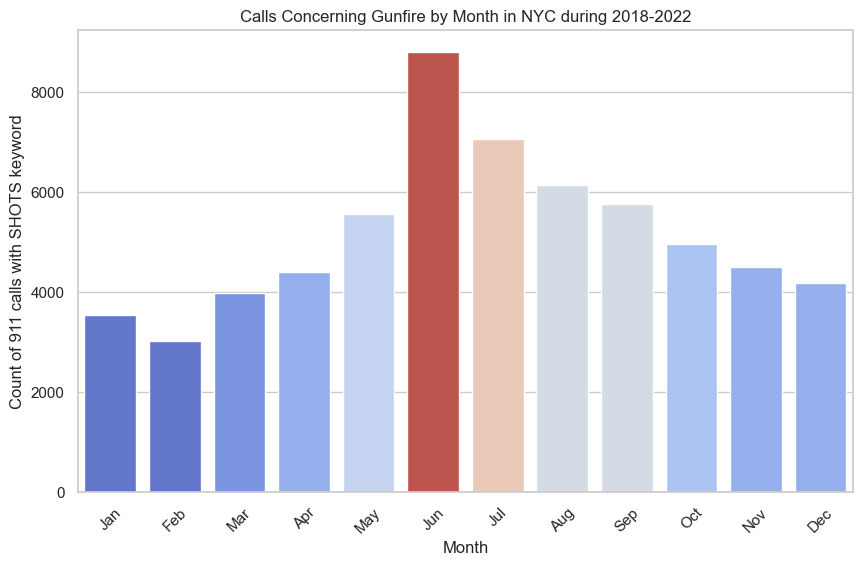

In [35]:
import pandas as pd
with conn.cursor() as curs:
    curs.execute("""SELECT EXTRACT('MONTH' FROM date) AS month_,
	                COUNT(CASE WHEN tb_call_data.typ_desc LIKE '%SHOTS%' THEN 1 END) AS count_shots_fired
                    FROM sch_nypd_calls_tables.tb_weather_data
                    INNER JOIN sch_nypd_calls_tables.tb_call_data
                        ON tb_weather_data.date = tb_call_data.incident_date
                    GROUP BY EXTRACT('MONTH' FROM date)
                    HAVING COUNT(*) > 0
                    ORDER BY EXTRACT('MONTH' FROM date);"""
                 )
    df = pd.DataFrame(curs.fetchall(), columns=['month_', 'count_shots_fired'])
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Convert numeric month values to abbreviated English month names
month_dict = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
df['month_'] = df['month_'].map(month_dict)

# Find the maximum and minimum count values to create a dynamic color mapping
max_count = df['count_shots_fired'].max()
min_count = df['count_shots_fired'].min()

# Calculate the range of count values
count_range = max_count - min_count

# Create a custom color palette ranging from cool to warm tones based on the count values
num_colors = len(df)
palette = sns.color_palette("coolwarm", num_colors)

# Calculate the color for each bar based on its count value
colors = [palette[int((count - min_count) / count_range * (num_colors - 1))] for count in df['count_shots_fired']]

# Create the bar graph with the custom colors
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(x='month_', y='count_shots_fired', data=df, palette=colors)
plt.xlabel('Month')
plt.ylabel('Count of 911 calls with SHOTS keyword')
plt.title('Calls Concerning Gunfire by Month in NYC during 2018-2022')
plt.xticks(rotation=45)

# # Add a bell curve (Gaussian distribution) without kernel density estimation
# sns.lineplot(x='month_', y='count_shots_fired', data=df, color='black', marker='o', label='Data')

# # Calculate the Gaussian distribution
# x_values = np.linspace(0, len(df) - 1, 100)
# mu, std = df['count_shots_fired'].mean(), df['count_shots_fired'].std()
# y_values = np.exp(-0.5 * ((x_values - mu) / std) ** 2) / (std * np.sqrt(2 * np.pi))

# # Plot the Gaussian curve
# plt.plot(x_values, y_values, color='blue', label='Gaussian (Bell) Curve', linestyle='--')
#plt.legend()
plt.show()

## Predicting Assaults in Brooklyn

In [50]:
import psycopg2
conn = psycopg2.connect(
    host=POSTGRES_HOST,
    port=POSTGRES_PORT,
    user=POSTGRES_USER,
    password=POSTGRES_PASSWORD,
    database=POSTGRES_DB 
)

In [45]:
with conn.cursor() as curs:
    curs.execute('''SELECT tb_call_data.incident_date as date,
	                COUNT(CASE WHEN tb_call_data.typ_desc LIKE '%ASSAULT (IN PROGRESS):%' AND BORO_NM = 'BROOKLYN' THEN 1 END) AS count_of_assaults_in_bk
	                FROM sch_nypd_calls_tables.tb_call_data
	                GROUP BY incident_date''')
    df = pd.DataFrame(curs.fetchall(), columns=['date', 'count_of_assaults_in_bk'])
    print(df.head())

InFailedSqlTransaction: current transaction is aborted, commands ignored until end of transaction block


16:00:57 - cmdstanpy - INFO - Chain [1] start processing
16:00:57 - cmdstanpy - INFO - Chain [1] done processing


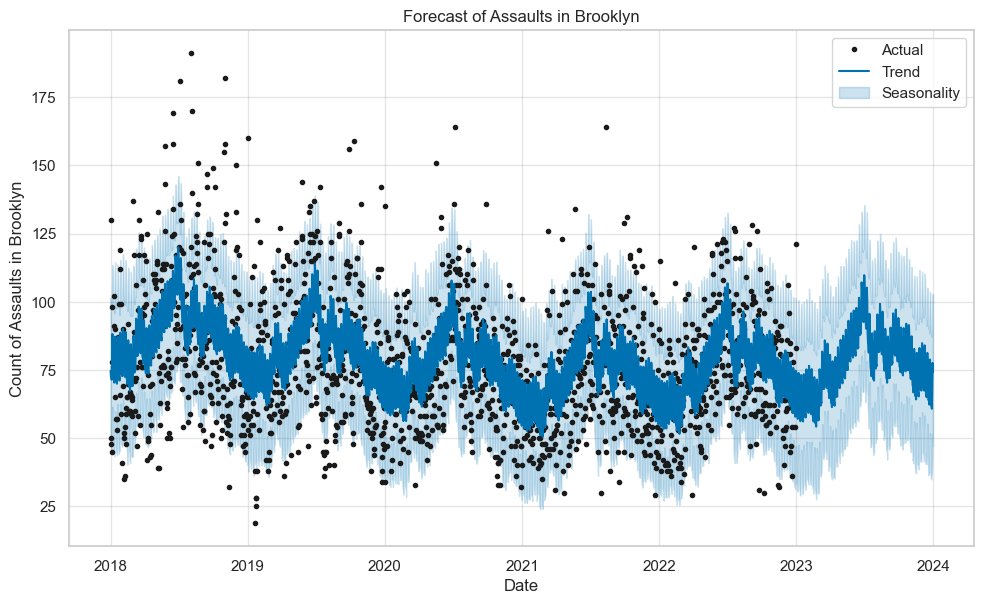

In [43]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Assuming you already have the data in the 'df' DataFrame

# Step 1: Prepare the data
df.rename(columns={'date': 'ds', 'count_of_assaults_in_bk': 'y'}, inplace=True)

# Step 2: Create and fit the Prophet model
model = Prophet()
model.fit(df)

# Step 3: Make predictions for future dates
future_dates = model.make_future_dataframe(periods=365)  # Forecasting for the next 365 days
forecast = model.predict(future_dates)

# Step 4: Plot the forecasted values
fig = model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Count of Assaults in Brooklyn')
plt.title('Forecast of Assaults in Brooklyn')
# Adding a legend to the plot
plt.legend(labels=['Actual', 'Trend', 'Seasonality', 'Forecast'], loc='upper right')
plt.show()


In [57]:
import psycopg2
from postgres_config import POSTGRES_DB, POSTGRES_HOST, POSTGRES_PASSWORD, POSTGRES_PORT, POSTGRES_USER
conn = psycopg2.connect(
    host=POSTGRES_HOST,
    port=POSTGRES_PORT,
    user=POSTGRES_USER,
    password=POSTGRES_PASSWORD,
    database=POSTGRES_DB 
)

In [59]:
with conn.cursor() as curs:
    curs.execute('''SELECT 
                    EXTRACT('MONTH' FROM tb_call_data.incident_date) AS date,
	                COUNT(CASE WHEN tb_call_data.typ_desc LIKE '%ASSAULT (IN PROGRESS):%' AND BORO_NM = 'BROOKLYN' THEN 1 END) AS count_of_assaults_in_bk
	                FROM sch_nypd_calls_tables.tb_call_data
                    GROUP BY EXTRACT('MONTH' FROM tb_call_data.incident_date)
	                ORDER BY count_of_assaults_in_bk DESC;

                 ''')
    df = pd.DataFrame(curs.fetchall(), columns=['date', 'count_of_assaults_in_bk'])
    print(df.head(12))

   date  count_of_assaults_in_bk
0     6                    13736
1     7                    13242
2     8                    13210
3     5                    12918
4     9                    12492
5    10                    12222
6     3                    11446
7     4                    11056
8    11                    10897
9    12                    10553
10    1                    10465
11    2                     9452


## Holidays Nov - Jan 2018/19

In [62]:
import psycopg2
from postgres_config import POSTGRES_DB, POSTGRES_HOST, POSTGRES_PASSWORD, POSTGRES_PORT, POSTGRES_USER
conn = psycopg2.connect(
    host=POSTGRES_HOST,
    port=POSTGRES_PORT,
    user=POSTGRES_USER,
    password=POSTGRES_PASSWORD,
    database=POSTGRES_DB 
)

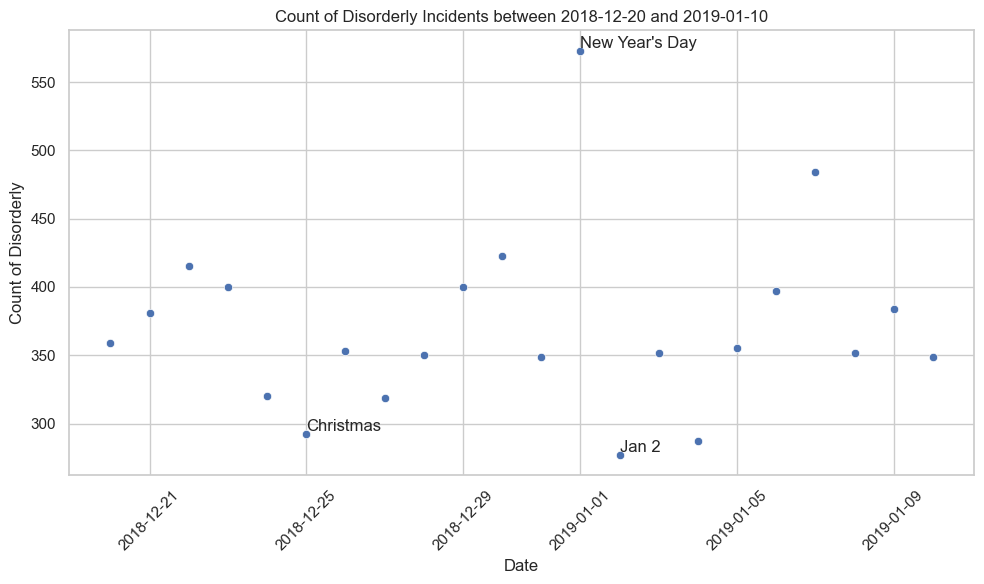

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

with conn.cursor() as curs:
	curs.execute("""SELECT tb_call_data.incident_date AS date,
	   COUNT(CASE WHEN tb_call_data.typ_desc LIKE '%DISORDERLY%' then 1 end) as count_of_disorderly
	   FROM sch_nypd_calls_tables.tb_call_data
	   WHERE incident_date BETWEEN '2018-12-20' AND '2019-01-10'
	   GROUP BY incident_date
	   ORDER By count_of_disorderly DESC"""
	)
	df = pd.DataFrame(curs.fetchall(), columns=['date', 'count_of_disorderly'])




# Convert the 'date' column to datetime type to ensure proper plotting
df['date'] = pd.to_datetime(df['date'])

# Define Christmas and New Year's Day dates
christmas_date = pd.to_datetime('2018-12-25')
new_years_date = pd.to_datetime('2019-01-01')
jan_second_date = pd.to_datetime('2019-01-02')
# Plot using seaborn and matplotlib
plt.figure(figsize=(10, 6))
sns.scatterplot(x='date', y='count_of_disorderly', data=df, color='b')

# Label the dots with 'New Year's Day' or 'Christmas'
for index, row in df.iterrows():
    if row['date'] == christmas_date:
        plt.text(row['date'], row['count_of_disorderly'], "Christmas", ha='left', va='bottom')
    elif row['date'] == new_years_date:
        plt.text(row['date'], row['count_of_disorderly'], "New Year's Day", ha='left', va='bottom')
    elif row['date'] == jan_second_date:
        plt.text(row['date'], row['count_of_disorderly'], "Jan 2", ha='left', va='bottom')
        
# Set plot aesthetics
plt.xlabel('Date')
plt.ylabel('Count of Disorderly')
plt.title('Count of Disorderly Incidents between 2018-12-20 and 2019-01-10')


# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

## Hottest Year In The Dataset

In [21]:
## Which was the hottest year in our dataset

with conn.cursor() as curs:
    curs.execute(
        """SELECT EXTRACT(YEAR FROM date) AS year,
           SUM(daily_temp_maximum) AS sum_of_temps
           FROM sch_nypd_calls_tables.tb_weather_data
           GROUP BY EXTRACT(YEAR FROM date)
           ORDER BY sum_of_temps DESC
           LIMIT 5;

           """
    )
    result = curs.fetchone()
    print(result)


(Decimal('2020'), 23010.299999999985)


In [2]:
import pandas as pd



with conn.cursor() as curs:
    curs.execute("""















                    """)
    
    df = pd.DataFrame(curs.fetchall(), columns=['incident_date', 'calls', 'daily_temp_high'])
    print(df.head())


  incident_date  calls  daily_temp_high
0    2018-01-01   2021             18.7
1    2018-01-02   1410             25.4
2    2018-01-03   1474             27.9
3    2018-01-04   1186             23.8
4    2018-01-05   1306             16.2


In [ ]:
import prophet as pt


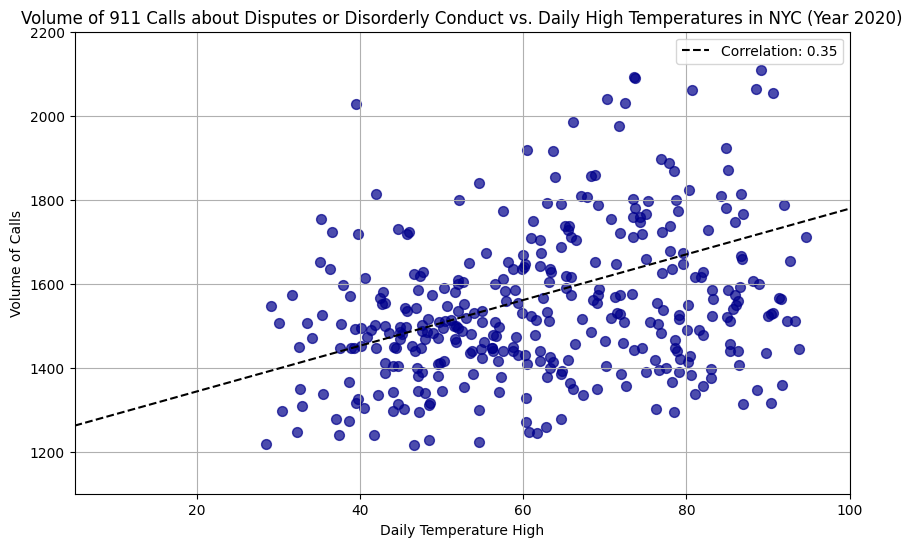

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Step 1: Convert the incident_date column to datetime format if it's not already in datetime format
df['incident_date'] = pd.to_datetime(df['incident_date'])

# Step 2: Plot the data using matplotlib without grouping
plt.figure(figsize=(10, 6))

# Step 3: Select the data for the specific year (2018 in this case)
year = 2020
data = df[df['incident_date'].dt.year == year]

# Step 4: Plot the scatter plot for the selected year
plt.scatter(data['daily_temp_high'], data['calls'], s=50, alpha=0.7, color='darkblue')

# Step 5: Calculate the correlation coefficient for the selected year
correlation_coefficient = data['daily_temp_high'].corr(data['calls'])

# Step 6: Fit a linear regression line to the data using polyfit
fit_coefficients = np.polyfit(data['daily_temp_high'], data['calls'], deg=1)

# Create the x values for the regression line
x_values = np.linspace(5, 100, 100)

# Calculate the corresponding y values using the fitted coefficients
y_values = fit_coefficients[0] * x_values + fit_coefficients[1]

# Plot the correlation line for the selected year
plt.plot(x_values, y_values, '--', color='black', label=f'Correlation: {correlation_coefficient:.2f}')

plt.xlabel('Daily Temperature High')
plt.ylabel('Volume of Calls Per Day')
plt.title(f'Volume of 911 Calls about Disputes or Disorderly Conduct vs. Daily High Temperatures in NYC (Year {year})')
plt.grid(True)
plt.xlim(5, 100)
plt.ylim(1100, 2200)  # Adjust the y-axis limits based on your data range

plt.legend()
plt.show()


## ALL OUT DIRECTED

In [57]:
import psycopg2
from postgres_config import POSTGRES_DB, POSTGRES_HOST, POSTGRES_PASSWORD, POSTGRES_PORT, POSTGRES_USER
conn = psycopg2.connect(
    host=POSTGRES_HOST,
    port=POSTGRES_PORT,
    user=POSTGRES_USER,
    password=POSTGRES_PASSWORD,
    database=POSTGRES_DB 
)

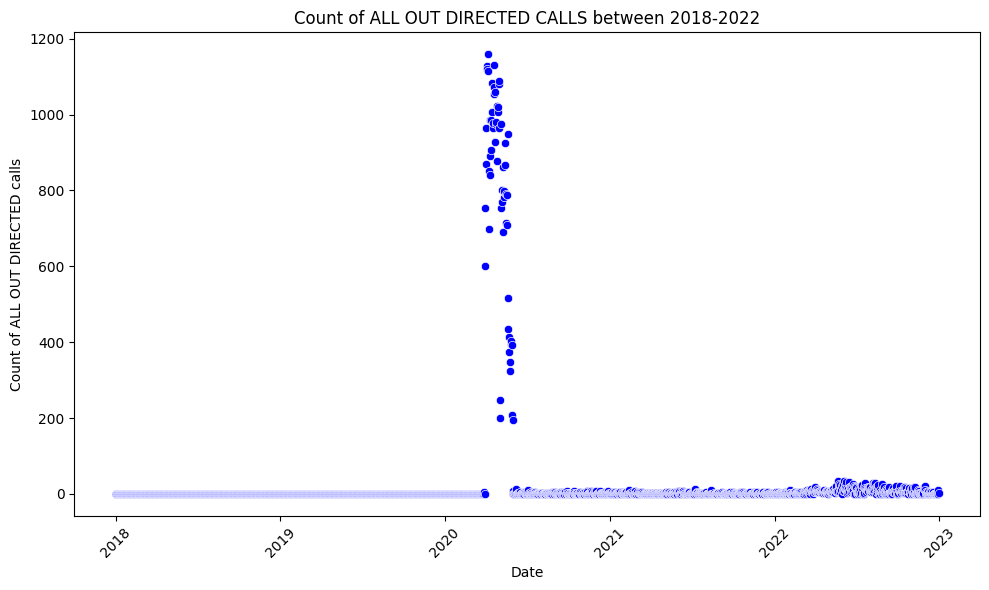

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

with conn.cursor() as curs:
	curs.execute("""
	   SELECT tcd.incident_date AS date,
       COUNT(CASE WHEN tcd.typ_desc = 'ALL OUT DIRECTED' THEN 1 END) as count_of_all_out
	   FROM sch_nypd_calls_tables.tb_call_data AS tcd
	   GROUP BY tcd.incident_date
	   --HAVING COUNT(CASE WHEN tcd.typ_desc = 'ALL OUT DIRECTED' THEN 1 END) >= 1
	   ORDER BY tcd.incident_date;
"""
	)
	df = pd.DataFrame(curs.fetchall(), columns=['date', 'count_of_all_out'])




# Convert the 'date' column to datetime type to ensure proper plotting
df['date'] = pd.to_datetime(df['date'])


plt.figure(figsize=(10, 6))
sns.scatterplot(x='date', y='count_of_all_out', data=df, color='b')

# Set plot aesthetics
plt.xlabel('Date')
plt.ylabel('Count of ALL OUT DIRECTED calls')
plt.title('Count of ALL OUT DIRECTED CALLS between 2018-2022')


# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

## Let's look at POSSIBLE SERIOUS CRIME 

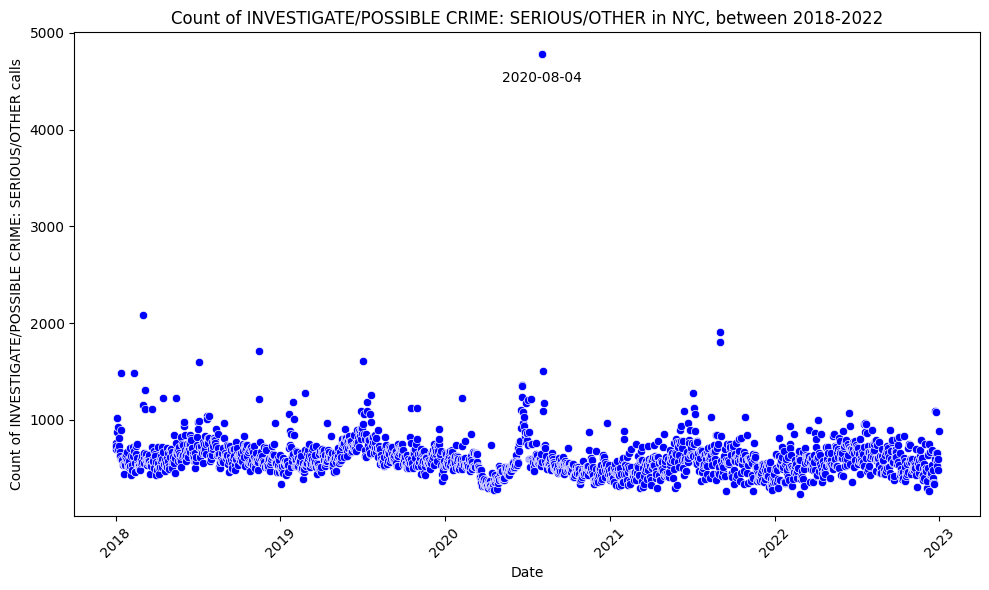

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

with conn.cursor() as curs:
	curs.execute("""
	   SELECT tcd.incident_date AS date,
       COUNT(CASE WHEN tcd.typ_desc = 'INVESTIGATE/POSSIBLE CRIME: SERIOUS/OTHER' THEN 1 END) as investigate_serious
	   FROM sch_nypd_calls_tables.tb_call_data AS tcd
	   GROUP BY tcd.incident_date
	   ORDER BY tcd.incident_date;
"""
	)
	df = pd.DataFrame(curs.fetchall(), columns=['date', 'investigate_serious'])




# Convert the 'date' column to datetime type to ensure proper plotting
df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(10, 6))
sns.scatterplot(x='date', y='investigate_serious', data=df, color='b')

# Find the highest value and its corresponding date
highest_value = df['investigate_serious'].max()
highest_date = df.loc[df['investigate_serious'].idxmax(), 'date']

# Annotate the highest point with the date (without arrow and below the point)
plt.annotate(highest_date.strftime('%Y-%m-%d'), xy=(highest_date, highest_value),
             xytext=(0, -20), textcoords='offset points',
             ha='center', fontsize=10)

# Set plot aesthetics
plt.xlabel('Date')
plt.ylabel('Count of INVESTIGATE/POSSIBLE CRIME: SERIOUS/OTHER calls')
plt.title('Count of INVESTIGATE/POSSIBLE CRIME: SERIOUS/OTHER in NYC, between 2018-2022')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

## Let's see what the outlier is in 2021

In [43]:
import psycopg2
from postgres_config import POSTGRES_DB, POSTGRES_HOST, POSTGRES_PASSWORD, POSTGRES_PORT, POSTGRES_USER
conn = psycopg2.connect(
    host=POSTGRES_HOST,
    port=POSTGRES_PORT,
    user=POSTGRES_USER,
    password=POSTGRES_PASSWORD,
    database=POSTGRES_DB 
)

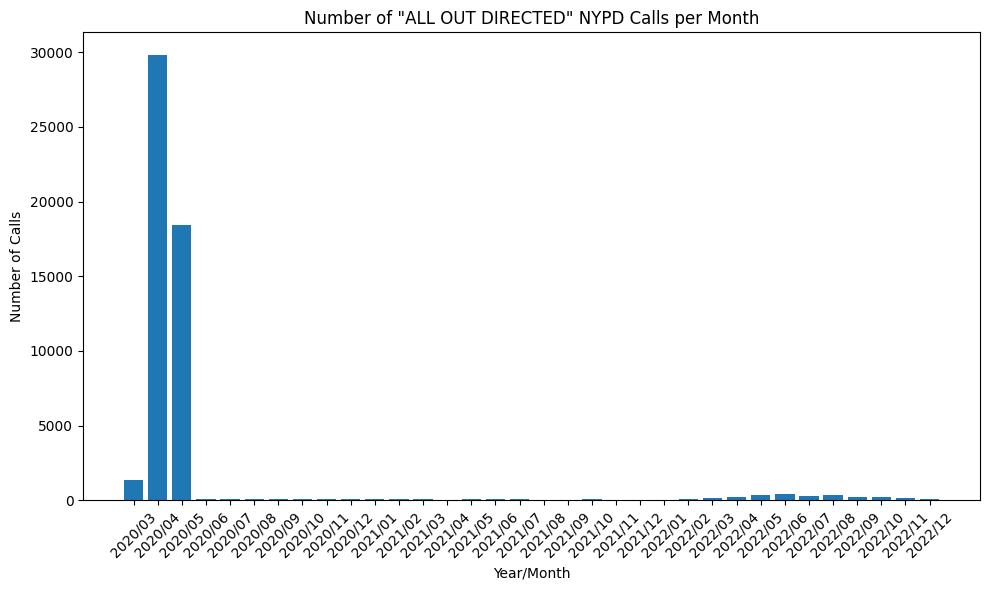

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

with conn.cursor() as curs:
	curs.execute("""
    SELECT EXTRACT(year FROM incident_date) AS year,
           EXTRACT(month FROM incident_date) AS month,
           COUNT(*) AS count_all_out
    FROM sch_nypd_calls_tables.tb_call_data
    WHERE typ_desc = 'ALL OUT DIRECTED'
    GROUP BY year, month
    ORDER BY year, month;
"""
	)
	df = pd.DataFrame(curs.fetchall(), columns=['year', 'month', 'count_all_out'])



# Create a new column combining year and month for x-axis labels
df['year_month'] = df['year'].astype(int).astype(str) + '/' + df['month'].astype(int).astype(str).str.zfill(2)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(df.index, df['count_all_out'])
plt.xticks(df.index, df['year_month'], rotation=45)
plt.xlabel('Year/Month')
plt.ylabel('Number of Calls')
plt.title('Number of "ALL OUT DIRECTED" NYPD Calls per Month')
plt.tight_layout()
plt.show()

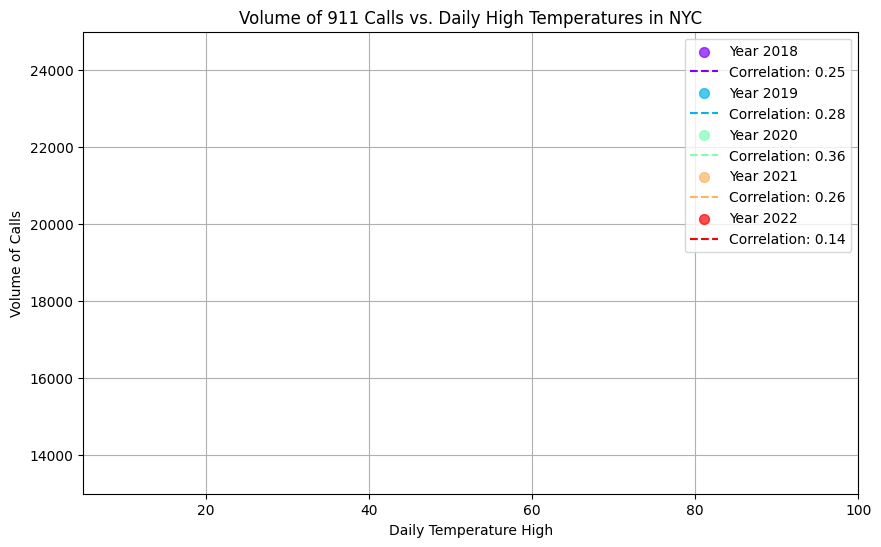

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



# Step 1: Convert the incident_date column to datetime format if it's not already in datetime format
df['incident_date'] = pd.to_datetime(df['incident_date'])

# Step 2: Plot the data using matplotlib without grouping
plt.figure(figsize=(10, 6))

# Step 3: Get the unique years present in the incident_date column
years = df['incident_date'].dt.year.unique()

# Step 4: Calculate the correlation coefficient for each year and plot the correlation line for each year
colors = plt.cm.rainbow(np.linspace(0, 1, len(years)))  # Create an array of colors for each year

for i, year in enumerate(years):
    data = df[df['incident_date'].dt.year == year]
    plt.scatter(data['daily_temp_high'], data['calls'], s=50, alpha=0.7, color=colors[i], label=f'Year {year}')

    # Calculate the correlation coefficient for the current year
    correlation_coefficient = data['daily_temp_high'].corr(data['calls'])

    # Fit a linear regression line to the data using polyfit
    fit_coefficients = np.polyfit(data['daily_temp_high'], data['calls'], deg=1)

    # Create the x values for the regression line
    x_values = np.linspace(5, 100, 100)

    # Calculate the corresponding y values using the fitted coefficients
    y_values = fit_coefficients[0] * x_values + fit_coefficients[1]

    # Plot the correlation line for the current year
    plt.plot(x_values, y_values, '--', color=colors[i], label=f'Correlation: {correlation_coefficient:.2f}')

plt.xlabel('Daily Temperature High')
plt.ylabel('Volume of Calls')
plt.title('Volume of 911 Calls vs. Daily High Temperatures in NYC')
plt.grid(True)
plt.xlim(5, 100)
plt.ylim(13000, 25000)

plt.legend()
plt.show()


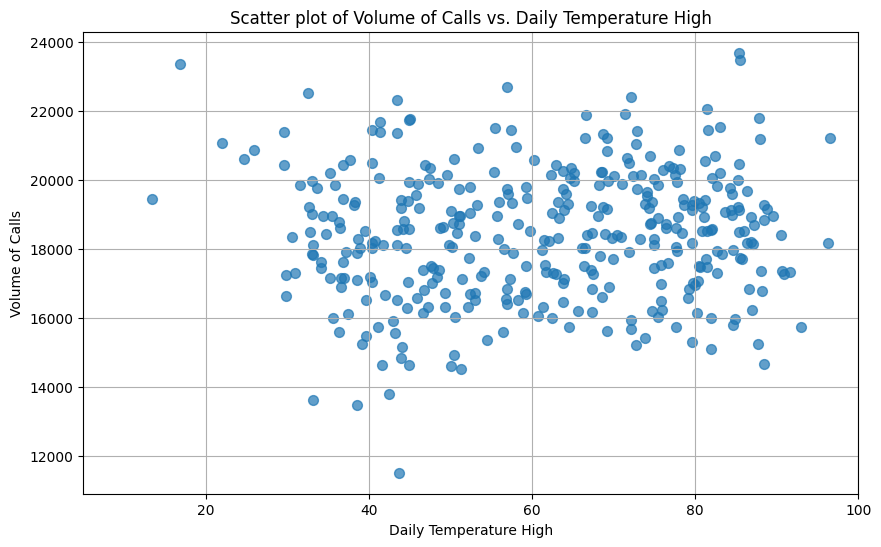

In [33]:
## 2019
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



# Step 1: Plot the data using matplotlib without grouping
plt.figure(figsize=(10, 6))
plt.scatter(df['daily_temp_high'], df['calls'], s=50, alpha=0.7)
plt.xlabel('Daily Temperature High')
plt.ylabel('Volume of Calls')
plt.title('Scatter plot of Volume of Calls vs. Daily Temperature High')
plt.grid(True)
# Set the x-axis limits to include the temperature range from -10 to 110 Fahrenheit
plt.xlim(5, 100)

plt.show()



In [ ]:
#analyzing the volume of 911 calls in NYC winter and summer 2018
#winter
#connect to postgres and query
with conn, conn.cursor() as curs:
    curs.execute("SELECT COUNT(typ_desc) AS count_winter FROM sch_nypd_calls_tables.tb_call_data WHERE (incident_date BETWEEN '2018-01-01' AND '2018-03-31')")
    # turn result into an integer
    winter_count = curs.fetchone()[0]
    print(f"There were {winter_count} 911 calls made in NYC in the winter of 2018")

#summer
#connect to postgres and query
with conn, conn.cursor() as curs:
    curs.execute("SELECT COUNT(table_1.typ_desc) as count_summer FROM sch_nypd_calls_tables.tb_call_data WHERE (incident_date BETWEEN '2018-06-01' AND '2018-08-31')")
    #turn result into an integer
    summer_count = curs.fetchone()[0]
    print(f"There were {summer_count} 911 calls made in NYC in the summer of 2018")

#see which had more calls and print the difference
if summer_count > winter_count:
    summer_lead = summer_count - winter_count
    print(f"So, there were {summer_lead} more 911 calls made in NYC in the summer of 2018")
else:
    winter_lead = winter_count - summer_count
    print(f"So, there were {winter_lead} more 911 calls made in NYC the winter of 2018")

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# Define the data for the bar graph

plt.ticklabel_format(style='plain')
# Create the bar graph
plt.ylim(0, 2000000) 
plt.bar(['Count of Summer Calls'], summer_count, label='Summmer 911 Calls', color='orange')
plt.bar(['Count of Winter Calls'], winter_count, label='Winter 911 Calls', color='blue')

# Add a title and axis labels
plt.title('911 Calls in NYC 2018')
plt.ylabel('Volume of Calls')
#
# # Add a legend
# plt.legend()

# Display the graph
plt.show()

In [ ]:
#analyzing the volume of 911 calls in NYC winter and summer 2018
#winter
#connect to postgres and query
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
with conn, conn.cursor() as curs:
    curs.execute("SELECT count(typ_desc) AS count_column, incident_date FROM sch_nypd_calls_tables.tb_call_data WHERE incident_date BETWEEN '2018-01-01' AND '2018-03-31' GROUP BY incident_date")
    # turn result into an integer
    df_winter = DataFrame(curs.fetchall(), columns=['count_column_winter', 'incident_date'])
    

#summer
#connect to postgres and query
with conn, conn.cursor() as curs:
    curs.execute("SELECT COUNT(typ_desc) AS count_column_summer, incident_date FROM sch_nypd_calls_tables.tb_call_data WHERE incident_date BETWEEN '2018-06-01' AND '2018-08-31' GROUP BY incident_date")
    df_summer = DataFrame(curs.fetchall(), columns=['count_column_summer', 'incident_date'])

# Calculate rolling average
window_size = 1  # Adjust the window size as desired
df_winter['rolling_average_winter'] = df_winter['count_column_winter'].rolling(window_size, min_periods=1).mean()
df_summer['rolling_average_summer'] = df_summer['count_column_summer'].rolling(window_size, min_periods=1).mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_winter['incident_date'], df_winter['rolling_average_winter'], label='Winter', color="blue")
plt.plot(df_summer['incident_date'], df_summer['rolling_average_summer'], label='Summer', color="orange")
plt.title('Volume of 911 Calls in Winter and Summer of 2018')
plt.xlabel('Incident Date')
plt.ylabel('Count')
plt.legend()
plt.show()



## Looking at calls about mischief over time per boro

In [15]:
import psycopg2
from postgres_config import POSTGRES_DB, POSTGRES_HOST, POSTGRES_PASSWORD, POSTGRES_PORT, POSTGRES_USER
conn = psycopg2.connect(
    host=POSTGRES_HOST,
    port=POSTGRES_PORT,
    user=POSTGRES_USER,
    password=POSTGRES_PASSWORD,
    database=POSTGRES_DB 
)

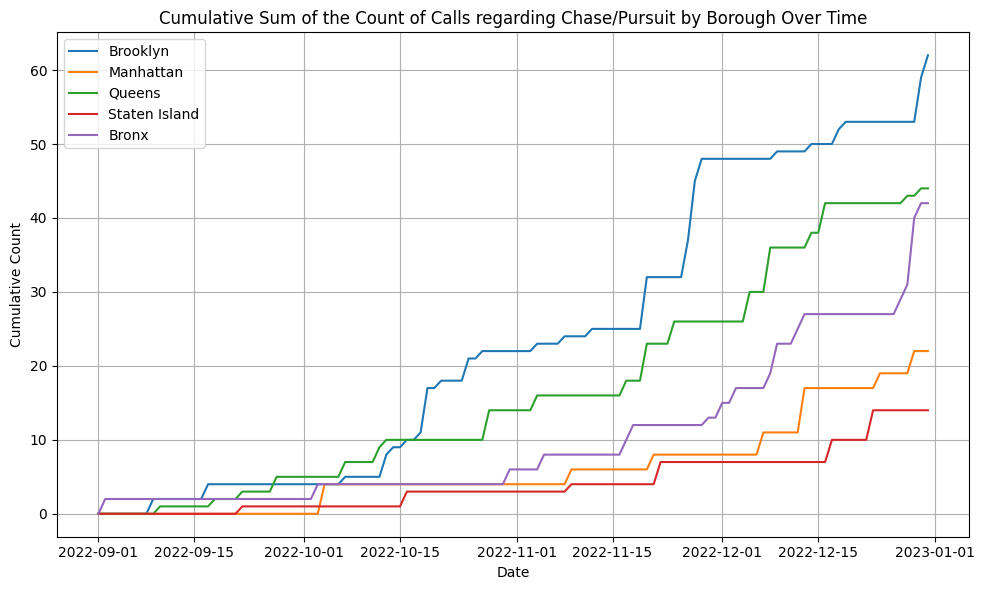

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
with conn.cursor() as curs:
	curs.execute("""
 SELECT
    DATE(incident_date) AS date,
    COUNT(CASE WHEN typ_desc = 'BROADCAST: CHASE/PURSUIT' AND boro_nm = 'BROOKLYN' THEN 1 ELSE NULL END) AS brooklyn_count,
    COUNT(CASE WHEN typ_desc = 'BROADCAST: CHASE/PURSUIT' AND boro_nm = 'MANHATTAN'THEN 1 ELSE NULL END) AS manhattan_count,
    COUNT(CASE WHEN typ_desc = 'BROADCAST: CHASE/PURSUIT' AND boro_nm = 'QUEENS' THEN 1 ELSE NULL END) AS queens_count,
    COUNT(CASE WHEN typ_desc = 'BROADCAST: CHASE/PURSUIT' AND boro_nm = 'STATEN ISLAND' THEN 1 ELSE NULL END) AS staten_island_count,
    COUNT(CASE WHEN typ_desc = 'BROADCAST: CHASE/PURSUIT' AND boro_nm = 'BRONX' THEN 1 ELSE NULL END) AS bronx_count
FROM
    sch_nypd_calls_tables.tb_call_data AS tcd
WHERE
	incident_date BETWEEN '2022-09-01' AND '2022-12-31'
GROUP BY
    incident_date
ORDER BY
    incident_date;
"""
	)
	df = pd.DataFrame(curs.fetchall(), columns=['date', 'brooklyn_count', 'manhattan_count','queens_count', 'staten_island_count', 'bronx_count'])
# Calculate the cumulative sum for each borough's count
df['brooklyn_cumsum'] = df['brooklyn_count'].cumsum()
df['manhattan_cumsum'] = df['manhattan_count'].cumsum()
df['queens_cumsum'] = df['queens_count'].cumsum()
df['staten_island_cumsum'] = df['staten_island_count'].cumsum()
df['bronx_cumsum'] = df['bronx_count'].cumsum()

# Create a line graph with the cumulative sums for each borough
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot the cumulative sums for each borough as a line graph
plt.plot(df['date'], df['brooklyn_cumsum'], label='Brooklyn', linestyle='-')
plt.plot(df['date'], df['manhattan_cumsum'], label='Manhattan', linestyle='-')
plt.plot(df['date'], df['queens_cumsum'], label='Queens', linestyle='-')
plt.plot(df['date'], df['staten_island_cumsum'], label='Staten Island', linestyle='-')
plt.plot(df['date'], df['bronx_cumsum'], label='Bronx', linestyle='-')

# Customize the plot
plt.title('Cumulative Sum of the Count of Calls regarding Chase/Pursuit by Borough Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Count')
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

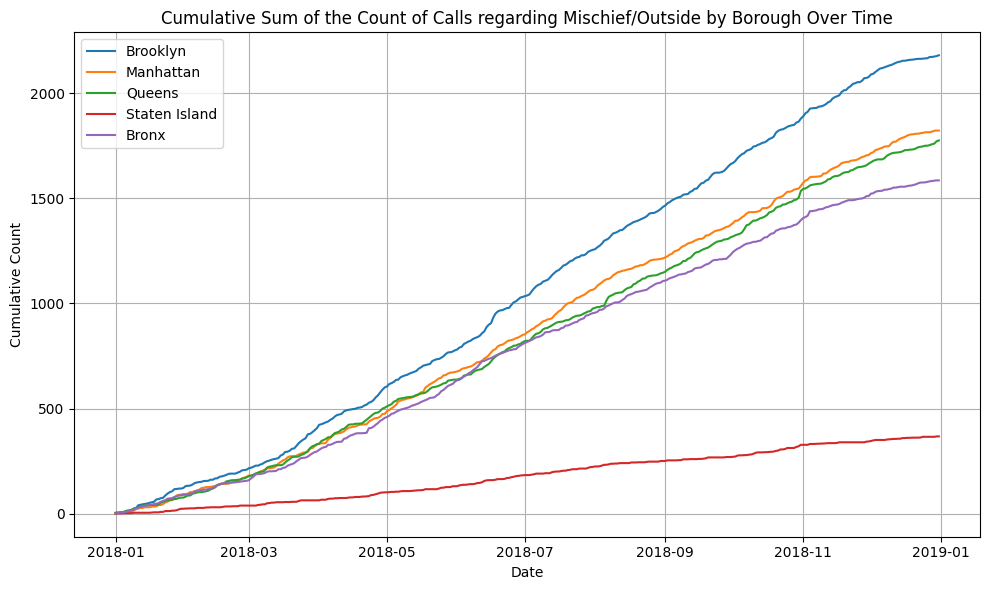

In [35]:

import pandas as pd
import matplotlib.pyplot as plt
with conn.cursor() as curs:
	curs.execute("""
 SELECT
    DATE(incident_date) AS date,
    COUNT(CASE WHEN typ_desc = 'OTHER CRIMES (IN PROGRESS): CRIM MISCHIEF/OUTSIDE' AND boro_nm = 'BROOKLYN' THEN 1 ELSE NULL END) AS brooklyn_count,
    COUNT(CASE WHEN typ_desc = 'OTHER CRIMES (IN PROGRESS): CRIM MISCHIEF/OUTSIDE' AND boro_nm = 'MANHATTAN'THEN 1 ELSE NULL END) AS manhattan_count,
    COUNT(CASE WHEN typ_desc = 'OTHER CRIMES (IN PROGRESS): CRIM MISCHIEF/OUTSIDE' AND boro_nm = 'QUEENS' THEN 1 ELSE NULL END) AS queens_count,
    COUNT(CASE WHEN typ_desc = 'OTHER CRIMES (IN PROGRESS): CRIM MISCHIEF/OUTSIDE' AND boro_nm = 'STATEN ISLAND' THEN 1 ELSE NULL END) AS staten_island_count,
    COUNT(CASE WHEN typ_desc = 'OTHER CRIMES (IN PROGRESS): CRIM MISCHIEF/OUTSIDE' AND boro_nm = 'BRONX' THEN 1 ELSE NULL END) AS bronx_count
FROM
    sch_nypd_calls_tables.tb_call_data AS tcd
WHERE
	incident_date BETWEEN '2018-01-01' AND '2018-12-31'
GROUP BY
    incident_date
ORDER BY
    incident_date;
"""
	)
	df = pd.DataFrame(curs.fetchall(), columns=['date', 'brooklyn_count', 'manhattan_count','queens_count', 'staten_island_count', 'bronx_count'])
# Calculate the cumulative sum for each borough's count
df['brooklyn_cumsum'] = df['brooklyn_count'].cumsum()
df['manhattan_cumsum'] = df['manhattan_count'].cumsum()
df['queens_cumsum'] = df['queens_count'].cumsum()
df['staten_island_cumsum'] = df['staten_island_count'].cumsum()
df['bronx_cumsum'] = df['bronx_count'].cumsum()

# Create a line graph with the cumulative sums for each borough
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot the cumulative sums for each borough as a line graph
plt.plot(df['date'], df['brooklyn_cumsum'], label='Brooklyn', linestyle='-')
plt.plot(df['date'], df['manhattan_cumsum'], label='Manhattan', linestyle='-')
plt.plot(df['date'], df['queens_cumsum'], label='Queens', linestyle='-')
plt.plot(df['date'], df['staten_island_cumsum'], label='Staten Island', linestyle='-')
plt.plot(df['date'], df['bronx_cumsum'], label='Bronx', linestyle='-')

# Customize the plot
plt.title('Cumulative Sum of the Count of Calls regarding Mischief/Outside by Borough Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Count')
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [55]:
import psycopg2
from postgres_config import POSTGRES_DB, POSTGRES_HOST, POSTGRES_PASSWORD, POSTGRES_PORT, POSTGRES_USER
conn = psycopg2.connect(
    host=POSTGRES_HOST,
    port=POSTGRES_PORT,
    user=POSTGRES_USER,
    password=POSTGRES_PASSWORD,
    database=POSTGRES_DB 
)

In [42]:

import pandas as pd
import matplotlib.pyplot as plt
with conn.cursor() as curs:
	curs.execute("""
WITH MischiefCounts AS (
    SELECT
        DATE(incident_date) AS date,
        SUM(CASE WHEN typ_desc = 'OTHER CRIMES (IN PROGRESS): CRIM MISCHIEF/OUTSIDE' AND boro_nm = 'BROOKLYN' THEN 1 ELSE 0 END) AS brooklyn_count,
        SUM(CASE WHEN typ_desc = 'OTHER CRIMES (IN PROGRESS): CRIM MISCHIEF/OUTSIDE' AND boro_nm = 'MANHATTAN' THEN 1 ELSE 0 END) AS manhattan_count,
        SUM(CASE WHEN typ_desc = 'OTHER CRIMES (IN PROGRESS): CRIM MISCHIEF/OUTSIDE' AND boro_nm = 'QUEENS' THEN 1 ELSE 0 END) AS queens_count,
        SUM(CASE WHEN typ_desc = 'OTHER CRIMES (IN PROGRESS): CRIM MISCHIEF/OUTSIDE' AND boro_nm = 'STATEN ISLAND' THEN 1 ELSE 0 END) AS staten_island_count,
        SUM(CASE WHEN typ_desc = 'OTHER CRIMES (IN PROGRESS): CRIM MISCHIEF/OUTSIDE' AND boro_nm = 'BRONX' THEN 1 ELSE 0 END) AS bronx_count
    FROM
        sch_nypd_calls_tables.tb_call_data AS tcd
    WHERE
        incident_date BETWEEN '2018-01-01' AND '2018-12-31'
    GROUP BY
        mischiefcounts.date
    ORDER BY
        date
)

SELECT
    date,
    SUM(brooklyn_cumulative_percentage) AS brooklyn_cumulative_percentage,
    SUM(manhattan_cumulative_percentage) AS manhattan_cumulative_percentage,
    SUM(queens_cumulative_percentage) AS queens_cumulative_percentage,
    SUM(staten_island_cumulative_percentage) AS staten_island_cumulative_percentage,
    SUM(bronx_cumulative_percentage) AS bronx_cumulative_percentage
FROM (
    SELECT
        date,
        (SUM(brooklyn_count) OVER (ORDER BY date) - brooklyn_count) * 100.0 / NULLIF(SUM(brooklyn_count) OVER (ORDER BY date) - LAG(SUM(brooklyn_count)) OVER (ORDER BY date), 0) AS brooklyn_cumulative_percentage,
        (SUM(manhattan_count) OVER (ORDER BY date) - manhattan_count) * 100.0 / NULLIF(SUM(manhattan_count) OVER (ORDER BY date) - LAG(SUM(manhattan_count)) OVER (ORDER BY date), 0) AS manhattan_cumulative_percentage,
        (SUM(queens_count) OVER (ORDER BY date) - queens_count) * 100.0 / NULLIF(SUM(queens_count) OVER (ORDER BY date) - LAG(SUM(queens_count)) OVER (ORDER BY date), 0) AS queens_cumulative_percentage,
        (SUM(staten_island_count) OVER (ORDER BY date) - staten_island_count) * 100.0 / NULLIF(SUM(staten_island_count) OVER (ORDER BY date) - LAG(SUM(staten_island_count)) OVER (ORDER BY date), 0) AS staten_island_cumulative_percentage,
        (SUM(bronx_count) OVER (ORDER BY date) - bronx_count) * 100.0 / NULLIF(SUM(bronx_count) OVER (ORDER BY date) - LAG(SUM(bronx_count)) OVER (ORDER BY date), 0) AS bronx_cumulative_percentage
    FROM
        MischiefCounts
) AS subquery
GROUP BY
    date
ORDER BY
    date;
"""
	)
	df = pd.DataFrame(curs.fetchall(), columns=['date', 'brooklyn_cumulative_growth_percentage', 'manhattan_cumulative_growth_percentage', 'queens_cumulative_growth_percentage', 'staten_island_cumulative_growth_percentage', 'bronx_cumulative_growth_percentage'])
# Plot each borough's growth as a line
plt.plot(df.index, df['brooklyn_cumulative_growth_percentage'], label='Brooklyn Cumulative Growth %')
plt.plot(df.index, df['manhattan_cumulative_growth_percentage'], label='Manhattan Cumulative Growth %')
plt.plot(df.index, df['queens_cumulative_growth_percentage'], label='Queens Cumulative Growth %')
plt.plot(df.index, df['staten_island_cumulative_growth_percentage'], label='Staten Cumulative Island Growth %')
plt.plot(df.index, df['bronx_cumulative_growth_percentage'], label='Bronx Cumulative Growth %')

plt.xlabel('Date')
plt.ylabel('Growth Percentage of Mischief Calls')
plt.title('Percentage Growth of Mischief Calls by Borough')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


UndefinedTable: missing FROM-clause entry for table "mischiefcounts"
LINE 15:         mischiefcounts.date
                 ^


## Percentage growth of mischief by boro

<Axes: xlabel='date'>

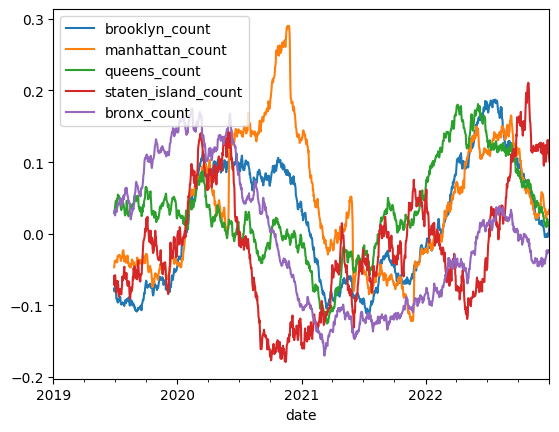

In [52]:
# SQL query to retrieve the data
with conn.cursor() as curs:
    curs.execute("""
    SELECT
        DATE(incident_date) AS date,
        COUNT(CASE WHEN typ_desc LIKE '%MISCHIEF%' AND boro_nm = 'BROOKLYN' THEN 1 ELSE NULL END) AS brooklyn_count,
        COUNT(CASE WHEN typ_desc LIKE '%MISCHIEF%' AND boro_nm = 'MANHATTAN' THEN 1 ELSE NULL END) AS manhattan_count,
        COUNT(CASE WHEN typ_desc LIKE '%MISCHIEF%' AND boro_nm = 'QUEENS' THEN 1 ELSE NULL END) AS queens_count,
        COUNT(CASE WHEN typ_desc LIKE '%MISCHIEF%' AND boro_nm = 'STATEN ISLAND' THEN 1 ELSE NULL END) AS staten_island_count,
        COUNT(CASE WHEN typ_desc LIKE '%MISCHIEF%' AND boro_nm = 'BRONX' THEN 1 ELSE NULL END) AS bronx_count
    FROM
        sch_nypd_calls_tables.tb_call_data AS tcd
    GROUP BY
        incident_date
    ORDER BY
        incident_date;
    """)

    df = pd.DataFrame(curs.fetchall(), columns=['date', 'brooklyn_count', 'manhattan_count', 'queens_count', 'staten_island_count', 'bronx_count'])
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.rolling(180).sum().pct_change(365).iloc[365:].plot()

## community time by borough and overall

In [76]:
import psycopg2
from postgres_config import POSTGRES_DB, POSTGRES_HOST, POSTGRES_PASSWORD, POSTGRES_PORT, POSTGRES_USER
conn = psycopg2.connect(
    host=POSTGRES_HOST,
    port=POSTGRES_PORT,
    user=POSTGRES_USER,
    password=POSTGRES_PASSWORD,
    database=POSTGRES_DB 
)

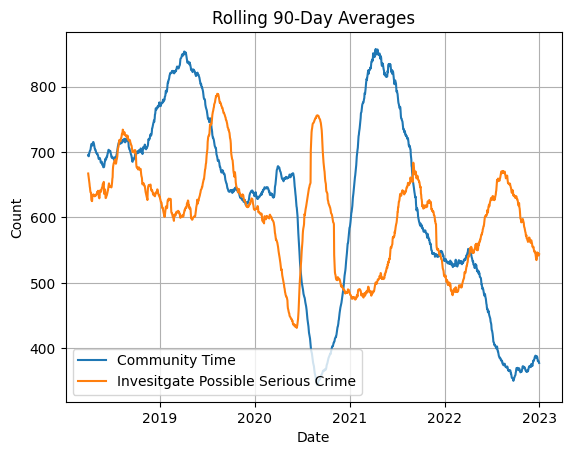

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
# SQL query to retrieve the data
with conn.cursor() as curs:
    curs.execute("""
    SELECT
        DATE(incident_date) AS date,
        COUNT(CASE WHEN typ_desc = 'COMMUNITY TIME' THEN 1 END) AS count_community_time,
        COUNT(CASE WHEN typ_desc = 'INVESTIGATE/POSSIBLE CRIME: SERIOUS/OTHER' THEN 1 END) AS count_investigate_serious
    FROM
        sch_nypd_calls_tables.tb_call_data AS tcd
    GROUP BY
        incident_date
    ORDER BY
        incident_date;
    """)
    df = pd.DataFrame(curs.fetchall(), columns=['date', 'count_community_time', 'count_investigate_serious'])

# Set 'date' as the index of the DataFrame
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Calculate the rolling 90-day average
rolling_average_community = df['count_community_time'].rolling(window=90).mean()
rolling_average_mischief = df['count_investigate_serious'].rolling(window=90).mean()
# Plot the rolling 90-day average

# Plot both rolling 90-day averages on the same graph
plt.plot(df.index, rolling_average_community, label='Community Time')
plt.plot(df.index, rolling_average_mischief, label='Invesitgate Possible Serious Crime')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Rolling 90-Day Averages')
plt.legend()
plt.grid(True)
plt.show()


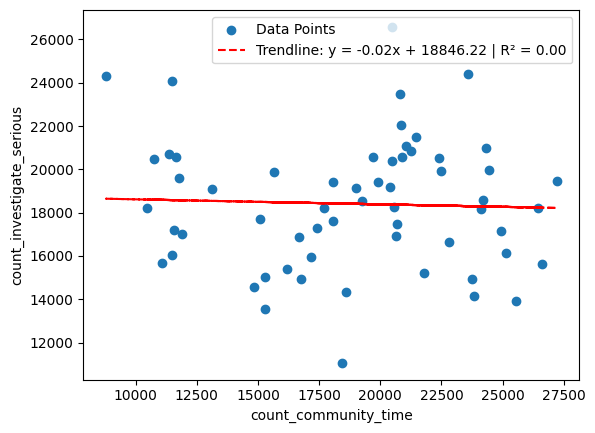

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# df['date'] = pd.to_datetime(df['date'])  # Convert the column to datetime if it's not already
# df.set_index('date', inplace=True)  # Set the 'timestamp' column as the index




df_resampled = df.resample('M').sum()

x = df_resampled['count_community_time']
y = df_resampled['count_investigate_serious']

# Create a scatter plot
plt.scatter(x, y, label='Data Points')

# Calculate the trendline
coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)

# Calculate R-squared value
y_pred = trendline(x)
y_mean = np.mean(y)
ss_total = np.sum((y - y_mean) ** 2)
ss_residual = np.sum((y - y_pred) ** 2)
r_squared = 1 - (ss_residual / ss_total)

# Plot the trendline with the R-squared value as a label
plt.plot(x, trendline(x), color='red', label=f'Trendline: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f} | R² = {r_squared:.2f}', linestyle='--')

# Add labels and legend
plt.xlabel('count_community_time')
plt.ylabel('count_investigate_serious')
plt.legend()

# Show the plot
plt.show()


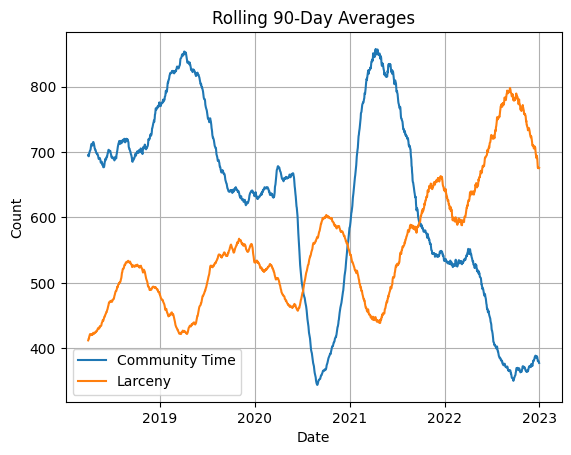

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
# SQL query to retrieve the data
with conn.cursor() as curs:
    curs.execute("""
    SELECT
        DATE(incident_date) AS date,
        COUNT(CASE WHEN typ_desc = 'COMMUNITY TIME' THEN 1 END) AS count_community_time,
        COUNT(CASE WHEN typ_desc LIKE '%LARCENY%' THEN 1 END) AS count_larceny
    FROM
        sch_nypd_calls_tables.tb_call_data AS tcd
    GROUP BY
        incident_date
    ORDER BY
        incident_date;
    """)
    df = pd.DataFrame(curs.fetchall(), columns=['date', 'count_community_time', 'count_larceny'])

# Set 'date' as the index of the DataFrame
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Calculate the rolling 90-day average
rolling_average_community = df['count_community_time'].rolling(window=90).mean()
rolling_average_mischief = df['count_larceny'].rolling(window=90).mean()
# Plot the rolling 90-day average

# Plot both rolling 90-day averages on the same graph
plt.plot(df.index, rolling_average_community, label='Community Time')
plt.plot(df.index, rolling_average_mischief, label='Larceny')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Rolling 90-Day Averages')
plt.legend()
plt.grid(True)
plt.show()


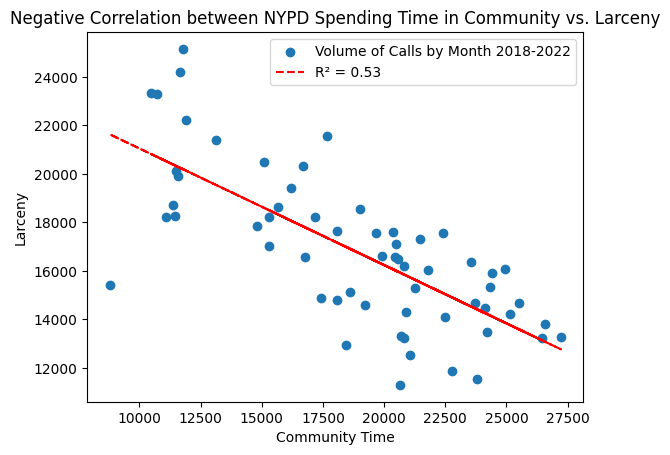

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# df['date'] = pd.to_datetime(df['date'])  # Convert the column to datetime if it's not already
# df.set_index('date', inplace=True)  # Set the 'timestamp' column as the index

df_resampled = df.resample('M').sum()

x = df_resampled['count_community_time']
y = df_resampled['count_larceny']

# Create a scatter plot
plt.scatter(x, y, label='Volume of Calls by Month 2018-2022')

# Calculate the trendline
coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)

# Calculate R-squared value
y_pred = trendline(x)
y_mean = np.mean(y)
ss_total = np.sum((y - y_mean) ** 2)
ss_residual = np.sum((y - y_pred) ** 2)
r_squared = 1 - (ss_residual / ss_total)

# Plot the trendline with the R-squared value as a label
#Trendline: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f} 
plt.plot(x, trendline(x), color='red', label=f'R² = {r_squared:.2f}', linestyle='--')

# Add labels and legend
plt.xlabel('Community Time')
plt.ylabel('Larceny')
plt.title('Negative Correlation between NYPD Spending Time in Community vs. Larceny')
plt.legend()

# Show the plot
plt.show()


<Figure size 1000x600 with 0 Axes>

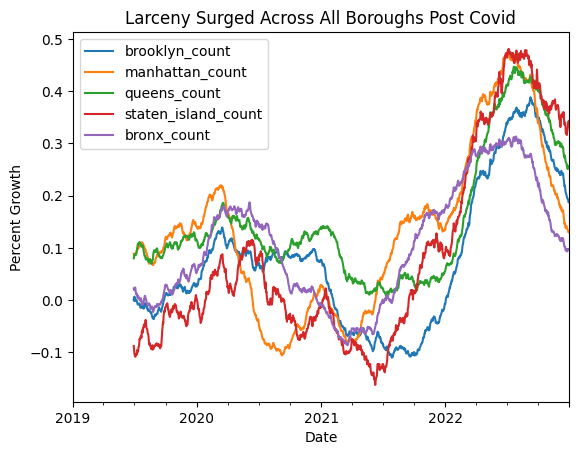

In [83]:
# SQL query to retrieve the data
with conn.cursor() as curs:
    curs.execute("""
    SELECT
        DATE(incident_date) AS date,
        COUNT(CASE WHEN boro_nm = 'BROOKLYN' THEN 1 ELSE NULL END) AS brooklyn_count,
        COUNT(CASE WHEN boro_nm = 'MANHATTAN' THEN 1 ELSE NULL END) AS manhattan_count,
        COUNT(CASE WHEN boro_nm = 'QUEENS' THEN 1 ELSE NULL END) AS queens_count,
        COUNT(CASE WHEN boro_nm = 'STATEN ISLAND' THEN 1 ELSE NULL END) AS staten_island_count,
        COUNT(CASE WHEN boro_nm = 'BRONX' THEN 1 ELSE NULL END) AS bronx_count
    FROM
        sch_nypd_calls_tables.tb_call_data AS tcd
    WHERE
        typ_desc LIKE '%LARCENY%'
    GROUP BY
        incident_date
    ORDER BY
        incident_date;
    """)

    df = pd.DataFrame(curs.fetchall(), columns=['date', 'brooklyn_count', 'manhattan_count', 'queens_count', 'staten_island_count', 'bronx_count'])
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
plt.figure(figsize=(10, 6))
df.rolling(180).sum().pct_change(365).iloc[365:].plot()

plt.xlabel('Date')
plt.ylabel('Percent Growth')
plt.title('Larceny Surged Across All Boroughs Post Covid')
plt.show()

<Figure size 1000x600 with 0 Axes>

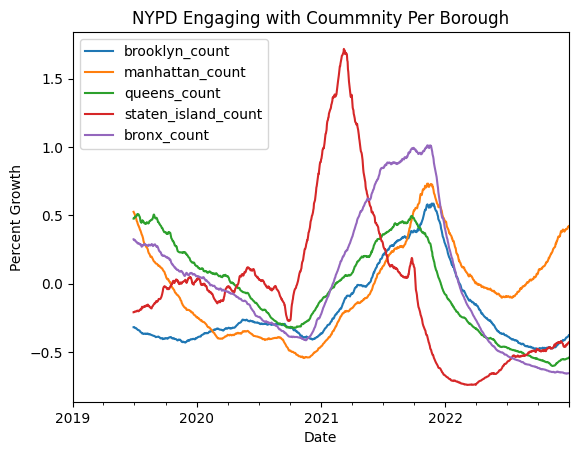

In [88]:
# SQL query to retrieve the data
with conn.cursor() as curs:
    curs.execute("""
    SELECT
        DATE(incident_date) AS date,
        COUNT(CASE WHEN boro_nm = 'BROOKLYN' THEN 1 ELSE NULL END) AS brooklyn_count,
        COUNT(CASE WHEN boro_nm = 'MANHATTAN' THEN 1 ELSE NULL END) AS manhattan_count,
        COUNT(CASE WHEN boro_nm = 'QUEENS' THEN 1 ELSE NULL END) AS queens_count,
        COUNT(CASE WHEN boro_nm = 'STATEN ISLAND' THEN 1 ELSE NULL END) AS staten_island_count,
        COUNT(CASE WHEN boro_nm = 'BRONX' THEN 1 ELSE NULL END) AS bronx_count
    FROM
        sch_nypd_calls_tables.tb_call_data AS tcd
    WHERE
        typ_desc = 'COMMUNITY TIME'
    GROUP BY
        incident_date
    ORDER BY
        incident_date;
    """)

    df = pd.DataFrame(curs.fetchall(), columns=['date', 'brooklyn_count', 'manhattan_count', 'queens_count', 'staten_island_count', 'bronx_count'])
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
plt.figure(figsize=(10, 6))
df.rolling(180).sum().pct_change(365).iloc[365:].plot()

plt.xlabel('Date')
plt.ylabel('Percent Growth')
plt.title('NYPD Engaging with Coummnity Per Borough')
plt.show()

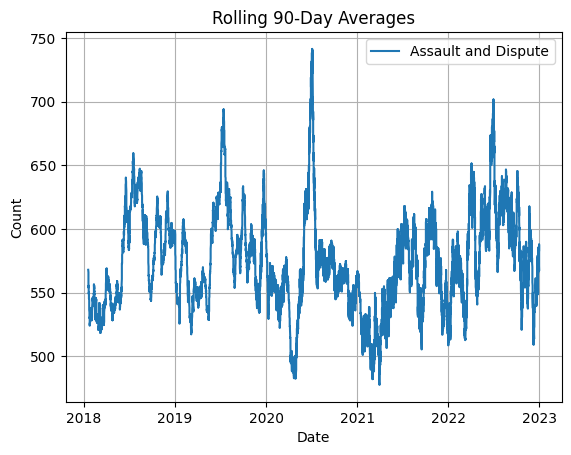

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
# SQL query to retrieve the data
with conn.cursor() as curs:
    curs.execute("""
    SELECT
        DATE(incident_date) AS date,
        boro_nm as borough,
        COUNT(CASE WHEN typ_desc = 'COMMUNITY TIME' THEN 1 END) AS count_community_time,
        COUNT(CASE WHEN 
            typ_desc LIKE '%LARCENY%' OR 
            typ_desc LIKE '%ROBBERY%' OR 
            typ_desc LIKE '%BURGLARY%' OR 
            typ_desc LIKE '%ASSAULT' OR 
            typ_desc LIKE '%DISPUTE%' OR 
            typ_desc LIKE '%MISCHIEF%' OR 
            typ_desc LIKE '%DISORDERLY%' 
            THEN 1 END) AS count_anger
    FROM
        sch_nypd_calls_tables.tb_call_data AS tcd
    GROUP BY
        date, borough;
    """)
    df = pd.DataFrame(curs.fetchall(), columns=['date', 'borough', 'count_community_time', 'count_anger'])

# Set 'date' as the index of the DataFrame
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Calculate the rolling 90-day average
#rolling_average_community = df['count_community_time'].rolling(window=90).mean()
rolling_average_assault = df['count_anger'].rolling(window=90).mean()
# Plot the rolling 90-day average

# Plot both rolling 90-day averages on the same graph
#plt.plot(df.index, rolling_average_community, label='Community Time')
plt.plot(df.index, rolling_average_assault, label='Assault and Dispute')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Rolling 90-Day Averages')
plt.legend()
plt.grid(True)
plt.show()


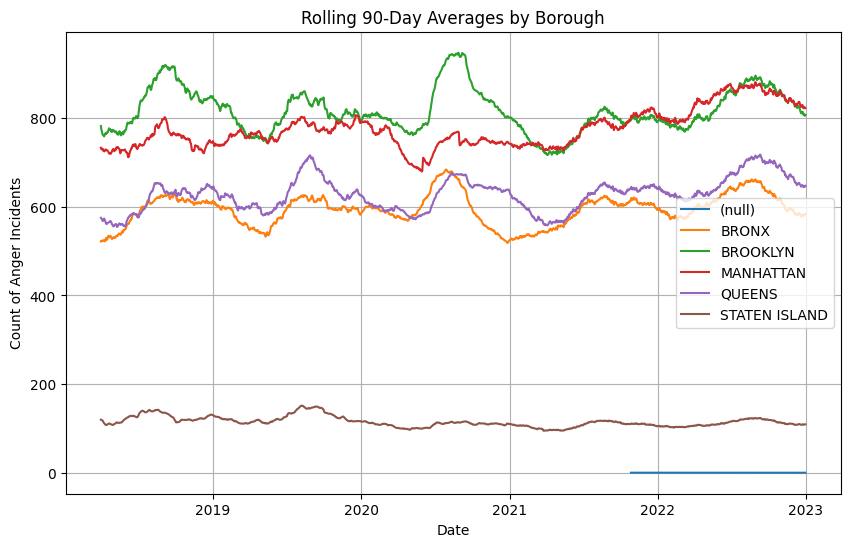

In [58]:

# SQL query to retrieve the data
# (Assuming you have already fetched and processed the data as shown in your code)
import pandas as pd
import matplotlib.pyplot as plt
# SQL query to retrieve the data
with conn.cursor() as curs:
    curs.execute("""
    SELECT
        DATE(incident_date) AS date,
        boro_nm as borough,
       -- COUNT(CASE WHEN typ_desc = 'COMMUNITY TIME' THEN 1 END) AS count_community_time,
        COUNT(CASE WHEN 
            typ_desc LIKE '%LARCENY%' OR 
            typ_desc LIKE '%ROBBERY%' OR 
            typ_desc LIKE '%BURGLARY%' OR 
            typ_desc LIKE '%ASSAULT' OR 
            typ_desc LIKE '%DISPUTE%' OR 
            typ_desc LIKE '%MISCHIEF%' OR 
            typ_desc LIKE '%DISORDERLY%' 
            THEN 1 END) AS count_anger
    FROM
        sch_nypd_calls_tables.tb_call_data AS tcd
    WHERE
        typ_desc IS NOT NULL OR boro_nm IS NOT NULL OR incident_date IS NOT NULL
    GROUP BY
        date, borough;
    """)
    df = pd.DataFrame(curs.fetchall(), columns=['date', 'borough', 'count_anger'])
# Set 'date' as the index of the DataFrame
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Calculate the rolling 90-day average for count_anger
rolling_average_assault = df.groupby('borough')['count_anger'].rolling(window=90).mean()

# Reset the index to plot the data by borough and date
rolling_average_assault = rolling_average_assault.reset_index()

# Plot the rolling 90-day average for each borough
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
for borough, data in rolling_average_assault.groupby('borough'):
    plt.plot(data['date'], data['count_anger'], label=borough)

plt.xlabel('Date')
plt.ylabel('Count of Anger Incidents')
plt.title('Rolling 90-Day Averages by Borough')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
df.rolling(180).sum().pct_change(365).iloc[365:].dropna().plot()

DataError: Cannot aggregate non-numeric type: object

In [ ]:


import pandas as pd
import matplotlib.pyplot as plt
# SQL query to retrieve the data
with conn.cursor() as curs:
    curs.execute("""
    SELECT
        DATE(incident_date) AS date,
        boro_nm as borough,
       -- COUNT(CASE WHEN typ_desc = 'COMMUNITY TIME' THEN 1 END) AS count_community_time,
        COUNT(CASE WHEN 
            typ_desc LIKE '%LARCENY%' OR 
            typ_desc LIKE '%ROBBERY%' OR 
            typ_desc LIKE '%BURGLARY%' OR 
            typ_desc LIKE '%ASSAULT' OR 
            typ_desc LIKE '%DISPUTE%' OR 
            typ_desc LIKE '%MISCHIEF%' OR 
            typ_desc LIKE '%DISORDERLY%' 
            THEN 1 END) AS count_anger
    FROM
        sch_nypd_calls_tables.tb_call_data AS tcd
    WHERE
        typ_desc IS NOT NULL OR boro_nm IS NOT NULL OR incident_date IS NOT NULL
    GROUP BY
        date, borough;
    """)
    df = pd.DataFrame(curs.fetchall(), columns=['date', 'borough', 'count_anger'])
# Set 'date' as the index of the DataFrame
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Calculate the rolling 90-day average for count_anger
rolling_average_assault = df.groupby('borough')['count_anger'].rolling(window=90).mean()

# Reset the index to plot the data by borough and date
rolling_average_assault = rolling_average_assault.reset_index()

# Plot the rolling 90-day average for each borough
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
for borough, data in rolling_average_assault.groupby('borough'):
    plt.plot(data['date'], data['count_anger'], label=borough)

plt.xlabel('Date')
plt.ylabel('Count of Anger Incidents')
plt.title('Rolling 90-Day Averages by Borough')
plt.legend()
plt.grid(True)
plt.show()

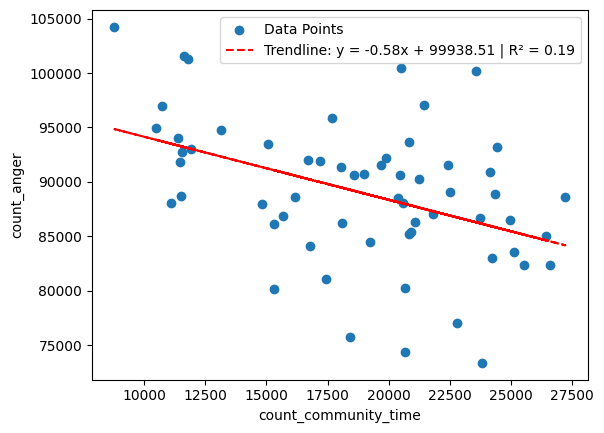

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df_resampled = df.resample('M').sum()

x = df_resampled['count_community_time']
y = df_resampled['count_anger']

# Create a scatter plot
plt.scatter(x, y, label='Data Points')

# Calculate the trendline
coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)

# Calculate R-squared value
y_pred = trendline(x)
y_mean = np.mean(y)
ss_total = np.sum((y - y_mean) ** 2)
ss_residual = np.sum((y - y_pred) ** 2)
r_squared = 1 - (ss_residual / ss_total)

# Plot the trendline with the R-squared value as a label
plt.plot(x, trendline(x), color='red', label=f'Trendline: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f} | R² = {r_squared:.2f}', linestyle='--')

# Add labels and legend
plt.xlabel('count_community_time')
plt.ylabel('count_anger')
plt.legend()

# Show the plot
plt.show()


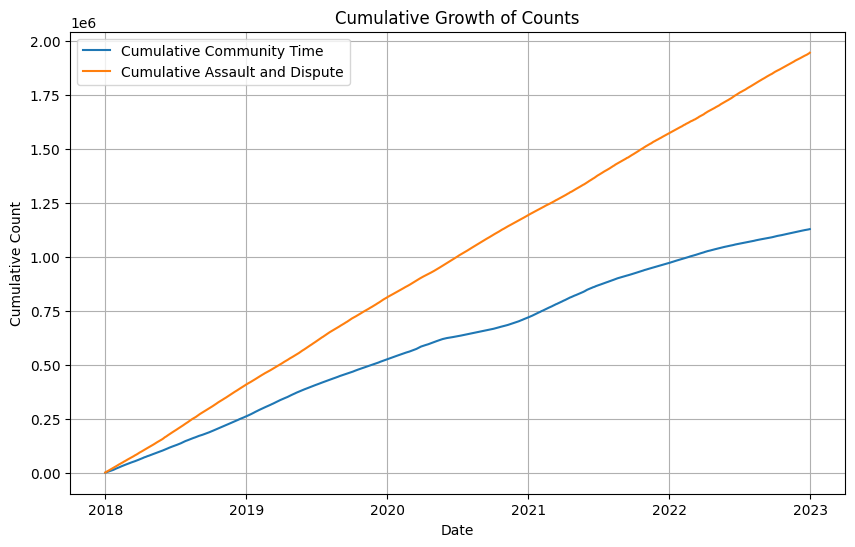

In [37]:
# Calculate the cumulative sum of each count
cumulative_sum_community = df['count_community_time'].cumsum()
cumulative_sum_anger = df['count_anger'].cumsum()

# Create a new figure for the cumulative growth plot
plt.figure(figsize=(10, 6))

# Plot the cumulative growth of each count
plt.plot(df.index, cumulative_sum_community, label='Cumulative Community Time', color='tab:blue')
plt.plot(df.index, cumulative_sum_anger, label='Cumulative Assault and Dispute', color='tab:orange')
plt.xlabel('Date')
plt.ylabel('Cumulative Count')
plt.title('Cumulative Growth of Counts')
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Comparison of Growth Rates of Calls about Community Time vs. Assault, Robbery, etc.')

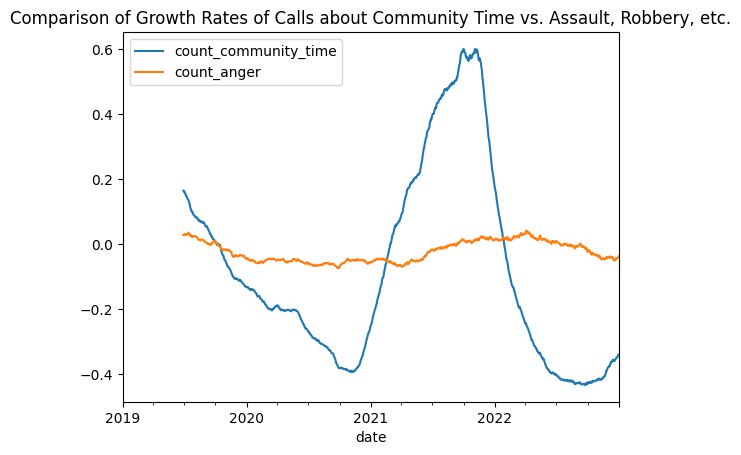

In [36]:
df.rolling(180).sum().pct_change(365).iloc[365:].plot()

#df.rolling(90).sum().plot()
plt.title('Comparison of Growth Rates of Calls about Community Time vs. Assault, Robbery, etc.')

## growth of community time vs michief

Text(0.5, 1.0, 'Comparison of Growth Rates of Calls about Community Time vs. Mischief')

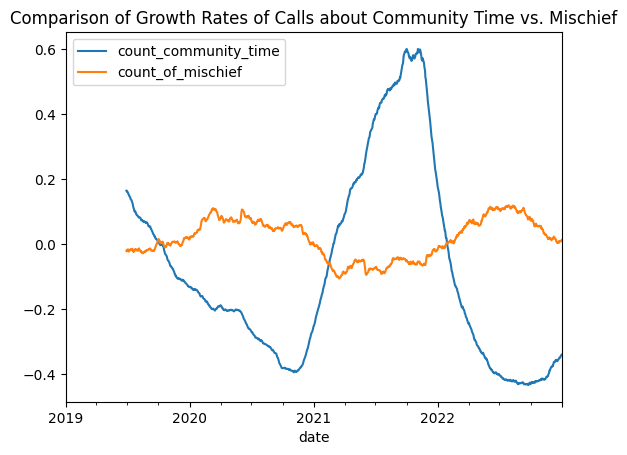

In [66]:
# SQL query to retrieve the data
with conn.cursor() as curs:
    curs.execute("""
    SELECT
        DATE(incident_date) AS date,
        COUNT(CASE WHEN typ_desc = 'COMMUNITY TIME' THEN 1 END) AS count_of_community_time,
        COUNT(CASE WHEN typ_desc LIKE '%MISCHIEF%' THEN 1 END) AS count_of_mischief
    FROM
        sch_nypd_calls_tables.tb_call_data AS tcd
    GROUP BY
        incident_date
    ORDER BY
        incident_date;
    """)

    df = pd.DataFrame(curs.fetchall(), columns=['date', 'count_community_time', 'count_of_mischief'])
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.rolling(180).sum().pct_change(365).iloc[365:].plot()

#df.rolling(90).sum().plot()
plt.title('Comparison of Growth Rates of Calls about Community Time vs. Mischief')

Text(0.5, 1.0, 'Correlaiton of Counts of 911 Calls About Mischief and Community Time')

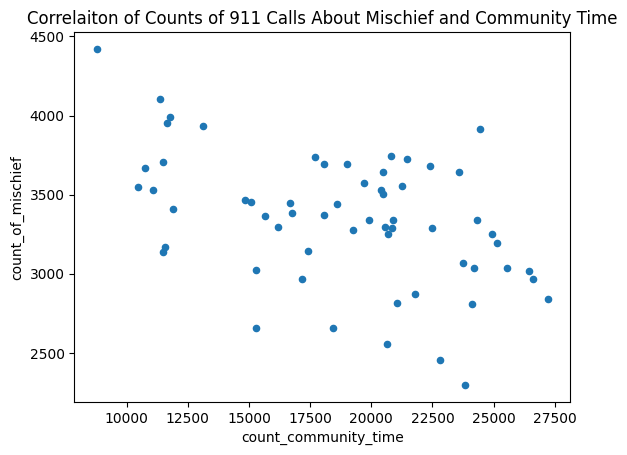

In [78]:
df.resample('M').sum().plot(kind='scatter',x='count_community_time', y='count_of_mischief')
plt.title('Correlaiton of Counts of 911 Calls About Mischief and Community Time')

<Axes: xlabel='count_community_time', ylabel='count_of_mischief'>

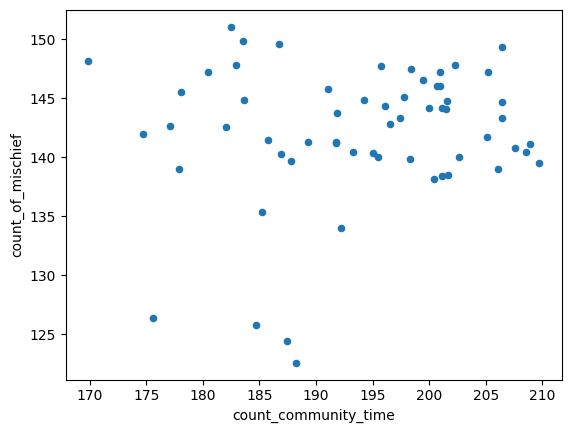

In [70]:
import numpy as np
df.apply(lambda x: np.log(x)).resample('M').sum().plot(kind='scatter',x='count_community_time', y='count_of_mischief')

<Axes: xlabel='count_community_time', ylabel='count_of_mischief'>

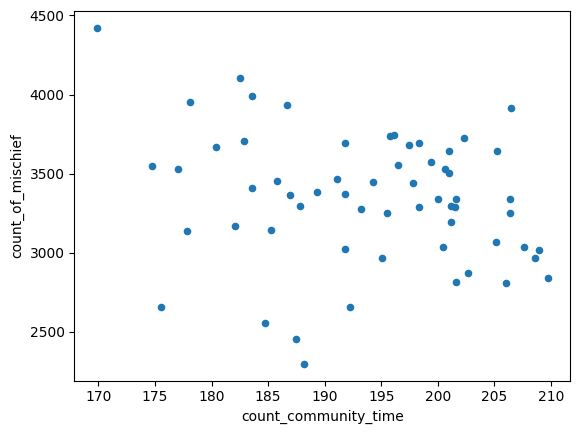

In [77]:
import numpy as np
dff = df.copy()
dff['count_community_time'] = np.log(dff['count_community_time'], )
dff.resample('M').sum().plot(kind='scatter',x='count_community_time', y='count_of_mischief')


Text(0.5, 1.0, 'Comparison of Growth Rates of Calls about Community Time vs. Mischief')

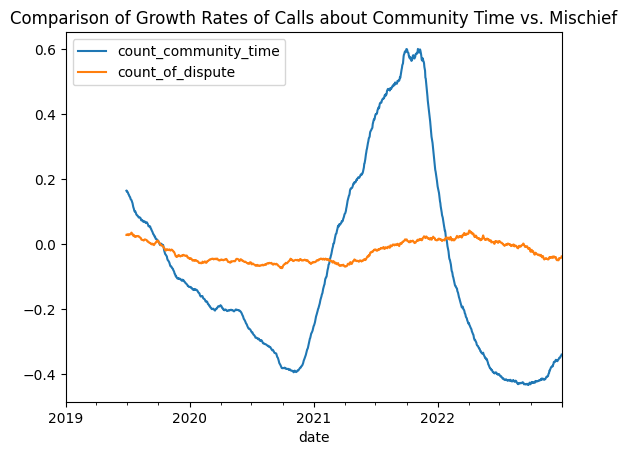

In [79]:
# SQL query to retrieve the data
with conn.cursor() as curs:
    curs.execute("""
    SELECT
        DATE(incident_date) AS date,
        COUNT(CASE WHEN typ_desc = 'COMMUNITY TIME' THEN 1 END) AS count_of_community_time,
        COUNT(CASE WHEN typ_desc LIKE '%DISPUTE%' THEN 1 END) AS count_of_dispute
    FROM
        sch_nypd_calls_tables.tb_call_data AS tcd
    GROUP BY
        incident_date
    ORDER BY
        incident_date;
    """)

    df = pd.DataFrame(curs.fetchall(), columns=['date', 'count_community_time', 'count_of_dispute'])
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.rolling(180).sum().pct_change(365).iloc[365:].plot()

#df.rolling(90).sum().plot()
plt.title('Comparison of Growth Rates of Calls about Community Time vs. Mischief')

Text(0.5, 1.0, 'Correlaiton of Counts of 911 Calls about community time vs disputes')

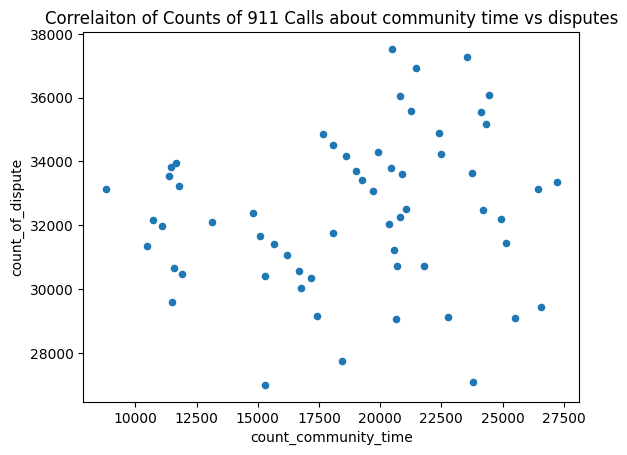

In [81]:
df.resample('M').sum().plot(kind='scatter',x='count_community_time', y='count_of_dispute')
plt.title('Correlaiton of Counts of 911 Calls about community time vs disputes')

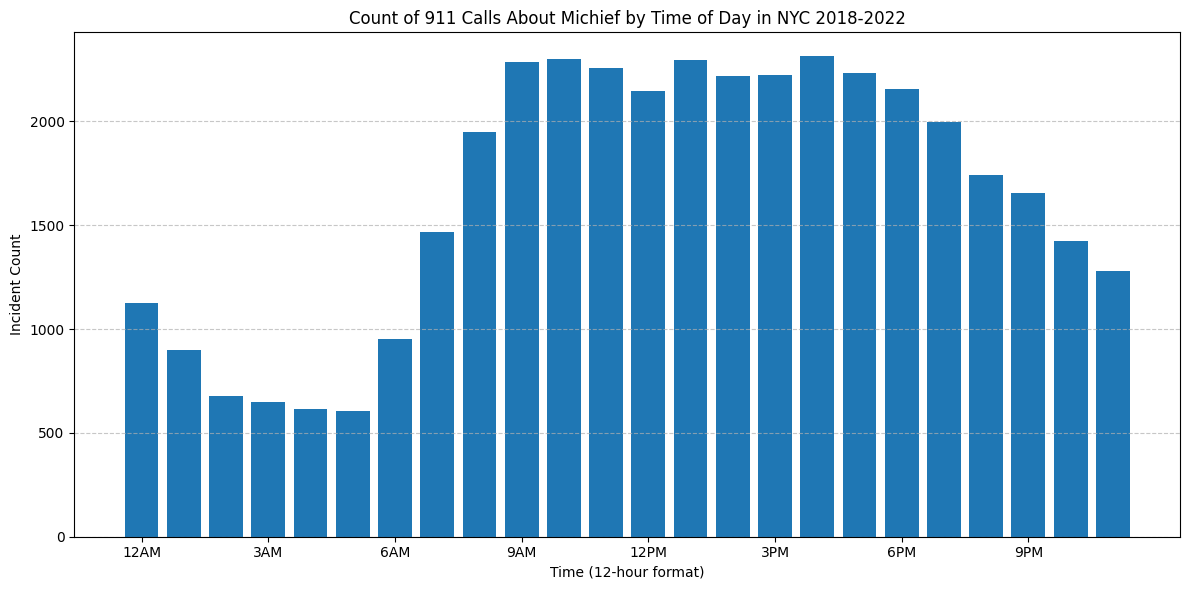

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# SQL query to retrieve the data
with conn.cursor() as curs:
    curs.execute("""
SELECT
    SUBSTRING(incident_time, 1, 2) AS hour,
    COUNT(*) AS incident_count
FROM sch_nypd_calls_tables.tb_call_data
WHERE typ_desc LIKE '%MISCHIEF%'
      AND incident_date BETWEEN '2018-01-01' AND '2018-12-31'
GROUP BY hour
ORDER BY hour;
    """)

    df = pd.DataFrame(curs.fetchall(), columns=['hour', 'incident_count'])

# Convert 'hour' column to integers
df['hour'] = df['hour'].astype(int)

# Create a new column with 12-hour time labels
df['time_label'] = df['hour'].apply(lambda x: f"{(x % 12) if x % 12 != 0 else 12}{'AM' if x < 12 else 'PM'}")

# Create a bar graph
plt.figure(figsize=(12, 6))
plt.bar(df['hour'], df['incident_count'], width=0.8, align='center')

# Set labels and title
plt.xlabel('Time (12-hour format)')
plt.ylabel('Incident Count')
plt.title('Count of 911 Calls About Michief by Time of Day in NYC 2018-2022')

# Set x-axis ticks to show labels every 3 hours
plt.xticks(np.arange(0, 24, 3), df['time_label'][::3])

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


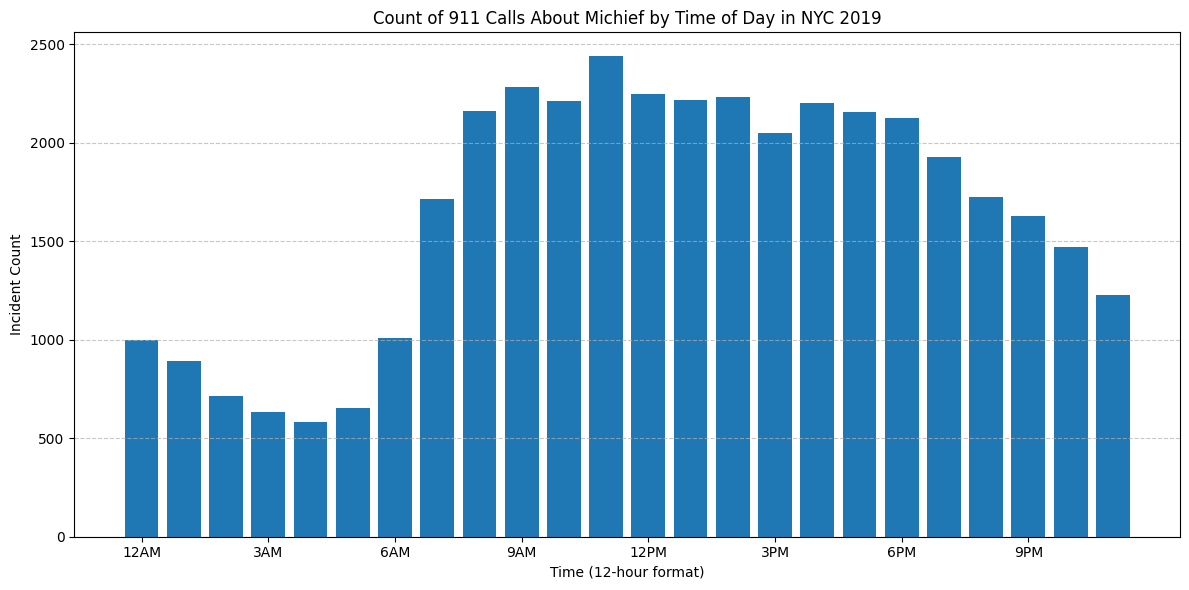

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# SQL query to retrieve the data
with conn.cursor() as curs:
    curs.execute("""
SELECT
    SUBSTRING(incident_time, 1, 2) AS hour,
    COUNT(*) AS incident_count
FROM sch_nypd_calls_tables.tb_call_data
WHERE typ_desc LIKE '%MISCHIEF%'
      AND incident_date BETWEEN '2019-01-01' AND '2019-12-31'
GROUP BY hour
ORDER BY hour;
    """)

    df = pd.DataFrame(curs.fetchall(), columns=['hour', 'incident_count'])

# Convert 'hour' column to integers
df['hour'] = df['hour'].astype(int)

# Create a new column with 12-hour time labels
df['time_label'] = df['hour'].apply(lambda x: f"{(x % 12) if x % 12 != 0 else 12}{'AM' if x < 12 else 'PM'}")

# Create a bar graph
plt.figure(figsize=(12, 6))
plt.bar(df['hour'], df['incident_count'], width=0.8, align='center')

# Set labels and title
plt.xlabel('Time (12-hour format)')
plt.ylabel('Incident Count')
plt.title('Count of 911 Calls About Michief by Time of Day in NYC 2019')

# Set x-axis ticks to show labels every 3 hours
plt.xticks(np.arange(0, 24, 3), df['time_label'][::3])

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of labels (1).

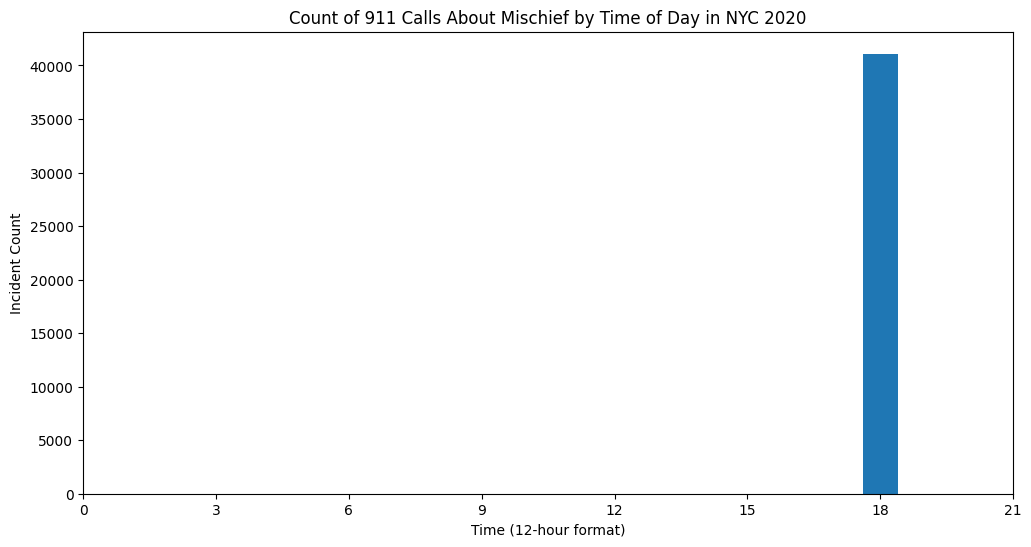

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# SQL query to retrieve the data
with conn.cursor() as curs:
    curs.execute("""
SELECT
    SUBSTRING(incident_time, 1, 2) AS hour,
    COUNT(*) AS incident_count
FROM sch_nypd_calls_tables.tb_call_data
WHERE typ_desc LIKE '%MISCHIEF%'
      AND incident_date BETWEEN '2020-01-01' AND '2020-12-31'
GROUP BY hour
ORDER BY hour;
    """)

    df = pd.DataFrame(curs.fetchall(), columns=['hour', 'incident_count'])

# Convert 'hour' column to integers
df['hour'] = df['hour'].astype(int)

# Create a new column with 12-hour time labels
df['time_label'] = df['hour'].apply(lambda x: f"{(x % 12) if x % 12 != 0 else 12}{'AM' if x < 12 else 'PM'}")

# Create a bar graph
plt.figure(figsize=(12, 6))
plt.bar(df['hour'], df['incident_count'], width=0.8, align='center')

# Set labels and title
plt.xlabel('Time (12-hour format)')
plt.ylabel('Incident Count')
plt.title('Count of 911 Calls About Mischief by Time of Day in NYC 2020')

# Set x-axis ticks to show labels every 3 hours
plt.xticks(np.arange(0, 24, 3), df['time_label'][::3])

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Burglary throughout the day

In [1]:
import psycopg2
from postgres_config import POSTGRES_DB, POSTGRES_HOST, POSTGRES_PASSWORD, POSTGRES_PORT, POSTGRES_USER
conn = psycopg2.connect(
    host=POSTGRES_HOST,
    port=POSTGRES_PORT,
    user=POSTGRES_USER,
    password=POSTGRES_PASSWORD,
    database=POSTGRES_DB 
)

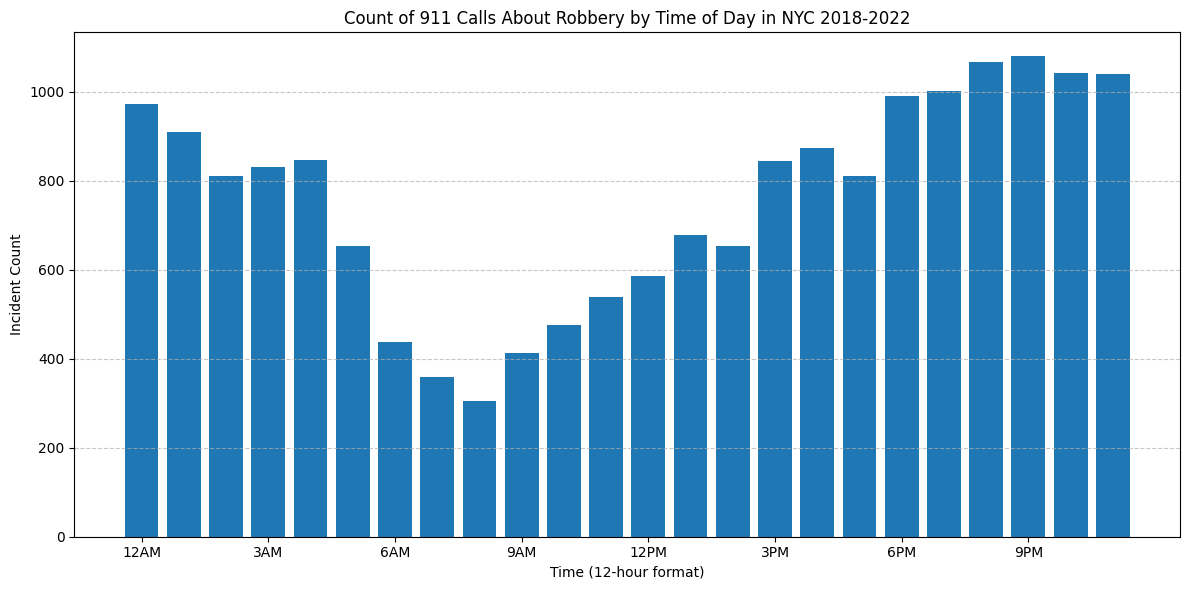

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# SQL query to retrieve the data
with conn.cursor() as curs:
    curs.execute("""
SELECT
    SUBSTRING(incident_time, 1, 2) AS hour,
    COUNT(*) AS incident_count
FROM sch_nypd_calls_tables.tb_call_data
WHERE typ_desc LIKE '%ROBBERY%'
      AND incident_date BETWEEN '2018-01-01' AND '2018-12-31'
GROUP BY hour
ORDER BY hour;
    """)

    df = pd.DataFrame(curs.fetchall(), columns=['hour', 'incident_count'])

# Convert 'hour' column to integers
df['hour'] = df['hour'].astype(int)

# Create a new column with 12-hour time labels
df['time_label'] = df['hour'].apply(lambda x: f"{(x % 12) if x % 12 != 0 else 12}{'AM' if x < 12 else 'PM'}")

# Create a bar graph
plt.figure(figsize=(12, 6))
plt.bar(df['hour'], df['incident_count'], width=0.8, align='center')

# Set labels and title
plt.xlabel('Time (12-hour format)')
plt.ylabel('Incident Count')
plt.title('Count of 911 Calls About Robbery by Time of Day in NYC 2018-2022')

# Set x-axis ticks to show labels every 3 hours
plt.xticks(np.arange(0, 24, 3), df['time_label'][::3])

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Mapping Data

In [1]:
import psycopg2
from postgres_config import POSTGRES_DB, POSTGRES_HOST, POSTGRES_PASSWORD, POSTGRES_PORT, POSTGRES_USER
conn = psycopg2.connect(
    host=POSTGRES_HOST,
    port=POSTGRES_PORT,
    user=POSTGRES_USER,
    password=POSTGRES_PASSWORD,
    database=POSTGRES_DB 
)

In [7]:
import folium
import sqlite3
import pandas as pd


# SQL query to fetch data
with conn.cursor() as curs:
    curs.execute("""
SELECT 
    (CASE WHEN typ_desc LIKE '%MISCHIEF%' THEN 1 END) AS mischief,
    latitude,
    longitude
FROM
    sch_nypd_calls_tables.tb_call_data
GROUP BY 
    mischief, latitude, longitude;
"""
    )
# Execute the query and create a DataFrame

    df = pd.DataFrame(curs.fetchall(), columns=['mischief', 'latitude', 'longitude'])

# Create a Folium map centered around New York
ny_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10)

# Add a heat map layer using the latitude and longitude from the DataFrame
heat_data = df[['latitude', 'longitude']].values.tolist()
folium.plugins.HeatMap(heat_data).add_to(ny_map)

# Display the map
ny_map.save('ny_heatmap.html')


AttributeError: module 'folium' has no attribute 'plugins'

In [3]:
import folium
import pandas as pd

# SQL query to fetch data
with conn.cursor() as curs:
    curs.execute("""
    SELECT 
        (CASE WHEN typ_desc = 'BROADCAST: CHASE/PURSUIT' THEN 1 END) AS chase,
        latitude,
        longitude
    FROM
        sch_nypd_calls_tables.tb_call_data;
    """
    )

# Execute the query and create a DataFrame
    df = pd.DataFrame(curs.fetchall(), columns=['chase', 'latitude', 'longitude'])

# Group by latitude and longitude, and count the number of chases at each location
chase_counts = df.groupby(['latitude', 'longitude']).size().reset_index(name='count')

# Create a Folium map centered around New York
ny_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10)

# Create a HeatMap layer using the latitude, longitude, and count from the DataFrame
heat_data = chase_counts[['latitude', 'longitude', 'count']].values.tolist()
folium.TileLayer('cartodbpositron').add_to(ny_map)  # Add a base layer
folium.FeatureGroup(name='HeatMap').add_to(ny_map)

# Loop through the data to add CircleMarkers based on the count
for lat, lon, count in heat_data:
    for _ in range(count):
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            fill=True,
            fill_opacity=0.6,
            color='red'
        ).add_to(ny_map)

# Display the map
ny_map


In [1]:
import psycopg2
from postgres_config import POSTGRES_DB, POSTGRES_HOST, POSTGRES_PASSWORD, POSTGRES_PORT, POSTGRES_USER
conn = psycopg2.connect(
    host=POSTGRES_HOST,
    port=POSTGRES_PORT,
    user=POSTGRES_USER,
    password=POSTGRES_PASSWORD,
    database=POSTGRES_DB 
)

ValueError: Expected 2D array, got 1D array instead:
array=[-9.78237895e-14 -9.19471720e-14].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
import pandas as pd
import folium
# SQL query to fetch data
with conn.cursor() as curs:
    curs.execute("""
    SELECT 
        COUNT(CASE WHEN typ_desc = 'BROADCAST: CHASE/PURSUIT' AND boro_nm = 'MANHATTAN' THEN 1 END) AS count_manhattan,
        COUNT(CASE WHEN typ_desc = 'BROADCAST: CHASE/PURSUIT' AND boro_nm = 'BROOKLYN' THEN 1 END) AS count_brooklyn,
        COUNT(CASE WHEN typ_desc = 'BROADCAST: CHASE/PURSUIT' AND boro_nm = 'STATEN ISLAND' THEN 1 END) AS count_staten_island,
        COUNT(CASE WHEN typ_desc = 'BROADCAST: CHASE/PURSUIT' AND boro_nm = 'BRONX' THEN 1 END) AS count_bronx,
        COUNT(CASE WHEN typ_desc = 'BROADCAST: CHASE/PURSUIT' AND boro_nm = 'QUEENS' THEN 1 END) AS count_queens
        latitude,
        longitude
    FROM
        sch_nypd_calls_tables.tb_call_data;
    """
    )

# Execute the query and create a DataFrame
    df = pd.DataFrame(curs.fetchall(), columns=['count_manhattan', 'count_brooklyn', 'count_staten_island', 'count_bronx', 'count_queens'])

In [1]:
import psycopg2
from postgres_config import POSTGRES_DB, POSTGRES_HOST, POSTGRES_PASSWORD, POSTGRES_PORT, POSTGRES_USER
conn = psycopg2.connect(
    host=POSTGRES_HOST,
    port=POSTGRES_PORT,
    user=POSTGRES_USER,
    password=POSTGRES_PASSWORD,
    database=POSTGRES_DB 
)

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
# Assuming you have loaded your data into df as before
with conn.cursor() as curs:
    curs.execute("""
    SELECT 
        COUNT(CASE WHEN typ_desc = 'BROADCAST: CHASE/PURSUIT' AND boro_nm = 'MANHATTAN' THEN 1 END) AS count_manhattan,
        COUNT(CASE WHEN typ_desc = 'BROADCAST: CHASE/PURSUIT' AND boro_nm = 'BROOKLYN' THEN 1 END) AS count_brooklyn,
        COUNT(CASE WHEN typ_desc = 'BROADCAST: CHASE/PURSUIT' AND boro_nm = 'STATEN ISLAND' THEN 1 END) AS count_staten_island,
        COUNT(CASE WHEN typ_desc = 'BROADCAST: CHASE/PURSUIT' AND boro_nm = 'BRONX' THEN 1 END) AS count_bronx,
        COUNT(CASE WHEN typ_desc = 'BROADCAST: CHASE/PURSUIT' AND boro_nm = 'QUEENS' THEN 1 END) AS count_queens
    FROM
        sch_nypd_calls_tables.tb_call_data;
    """
    )

# Execute the query and create a DataFrame
    df = pd.DataFrame(curs.fetchall(), columns=['count_manhattan', 'count_brooklyn', 'count_staten_island', 'count_bronx', 'count_queens'])
# Convert the counts from the separate columns into a single column format
borough_counts = {
    'MANHATTAN': df['count_manhattan'].sum(),
    'BROOKLYN': df['count_brooklyn'].sum(),
    'STATEN ISLAND': df['count_staten_island'].sum(),
    'BRONX': df['count_bronx'].sum(),
    'QUEENS': df['count_queens'].sum()
}

# Convert the dictionary to a DataFrame
count_df = pd.DataFrame(list(borough_counts.items()), columns=['boro_nm', 'count'])

# Load the NYC borough shapefile
gdf = gpd.read_file('Borough_Boundaries')  # Replace with your shapefile path

# Merge the count data with the shapefile
merged = gdf.set_index('boro_name').join(count_df.set_index('boro_nm'))

# Plotting
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column='count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Convert matplotlib plot to an interactive leaflet map
mplleaflet.show(fig=ax.figure)


AttributeError: 'XAxis' object has no attribute '_gridOnMajor'

In [4]:
print(gdf.columns)


Index(['boro_code', 'boro_name', 'shape_area', 'shape_leng', 'geometry'], dtype='object')


In [ ]:
import geopandas as gpd
import pandas as pd
import folium


with conn.cursor() as curs:
    curs.execute("""
    SELECT 
        COUNT(CASE WHEN typ_desc = 'BROADCAST: CHASE/PURSUIT' AND boro_nm = 'MANHATTAN' THEN 1 END) AS count_manhattan,
        COUNT(CASE WHEN typ_desc = 'BROADCAST: CHASE/PURSUIT' AND boro_nm = 'BROOKLYN' THEN 1 END) AS count_brooklyn,
        COUNT(CASE WHEN typ_desc = 'BROADCAST: CHASE/PURSUIT' AND boro_nm = 'STATEN ISLAND' THEN 1 END) AS count_staten_island,
        COUNT(CASE WHEN typ_desc = 'BROADCAST: CHASE/PURSUIT' AND boro_nm = 'BRONX' THEN 1 END) AS count_bronx,
        COUNT(CASE WHEN typ_desc = 'BROADCAST: CHASE/PURSUIT' AND boro_nm = 'QUEENS' THEN 1 END) AS count_queens
    FROM
        sch_nypd_calls_tables.tb_call_data;
    """
    )

    # Execute the query and create a DataFrame
    df = pd.DataFrame(curs.fetchall(), columns=['count_manhattan', 'count_brooklyn', 'count_staten_island', 'count_bronx', 'count_queens'])

# Convert the counts from the separate columns into a single column format
borough_counts = {
    'MANHATTAN': df['count_manhattan'].sum(),
    'BROOKLYN': df['count_brooklyn'].sum(),
    'STATEN ISLAND': df['count_staten_island'].sum(),
    'BRONX': df['count_bronx'].sum(),
    'QUEENS': df['count_queens'].sum()
}

# Convert the dictionary to a DataFrame
count_df = pd.DataFrame(list(borough_counts.items()), columns=['boro_nm', 'count'])

# Load the NYC borough shapefile
gdf = gpd.read_file('Borough_Boundaries\geo_export_cf3e681d-2715-4727-9012-41417e653d1e.shp')  # Replace with your shapefile path

# Merge the GeoDataFrame with the count DataFrame
merged = gdf.merge(count_df, left_on='boro_name', right_on='boro_nm')

# Create a base map
m = folium.Map([40.730610, -73.935242], zoom_start=10)  # These coordinates are centered on NYC

# Convert the GeoDataFrame geometry to JSON
geo_json = merged.to_json()

# Plot the data
folium.Choropleth(
    geo_data=geo_json,
    name='choropleth',
    data=merged,
    columns=['boro_name', 'count'],
    key_on='feature.properties.boro_name',
    fill_color='BuPu',  # Blue-Purple colormap
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Calls'
).add_to(m)

# Add a Layer Control
folium.LayerControl().add_to(m)

m
#m.save('NYC_calls.html')  # This will save the map to an HTML file


In [5]:
import psycopg2
from postgres_config import POSTGRES_DB, POSTGRES_HOST, POSTGRES_PASSWORD, POSTGRES_PORT, POSTGRES_USER
conn = psycopg2.connect(
    host=POSTGRES_HOST,
    port=POSTGRES_PORT,
    user=POSTGRES_USER,
    password=POSTGRES_PASSWORD,
    database=POSTGRES_DB 
)

c:\Project_Files\nypd_calls_for_service_git\calls_for_service_nypd_venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Project_Files\nypd_calls_for_service_git\calls_for_service_nypd_venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Project_Files\nypd_calls_for_service_git\calls_for_service_nypd_venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Project_Files\nypd_calls_for_service_git\calls_for_service_nypd_venv\Lib\site-packages\s

TypeError: unsupported operand type(s) for *: 'decimal.Decimal' and 'float'

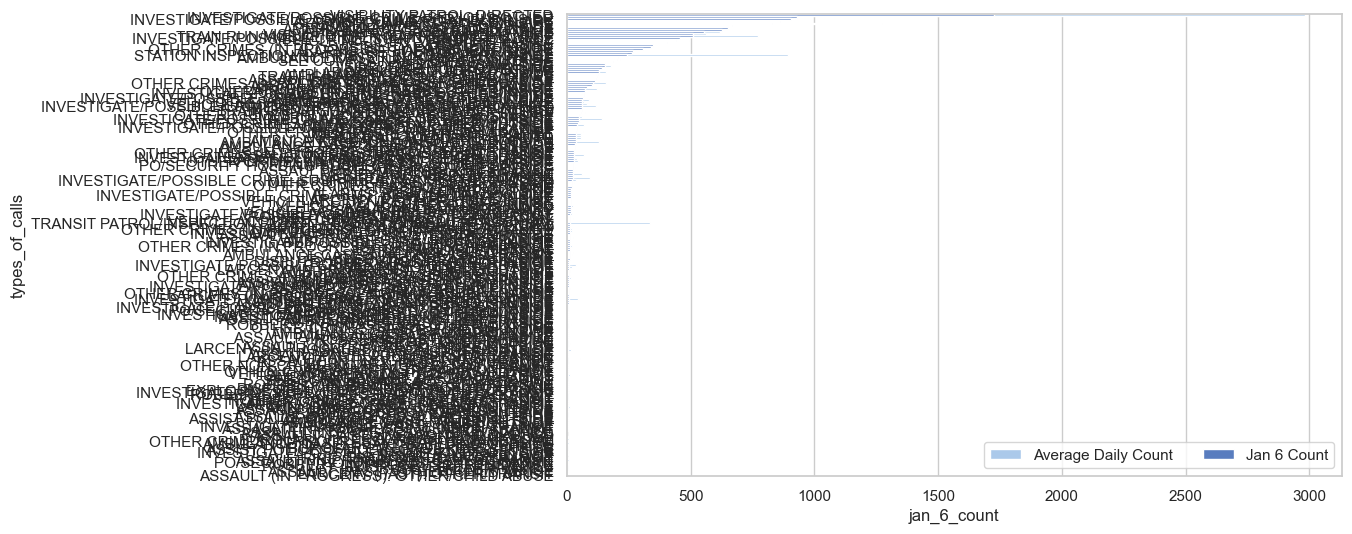

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

with conn.cursor() as curs:
    curs.execute("""
    SELECT
    j.typ_desc AS types_of_calls,
    j.jan_6_count AS jan_6_count,
    AVG(d.daily_count) AS avg_daily_count
FROM
    (
        SELECT
            typ_desc,
            COUNT(*) as jan_6_count
        FROM
            sch_nypd_calls_tables.tb_call_data
        WHERE
            DATE(incident_date) = '2018-01-06'
        GROUP BY
            typ_desc
    ) AS j
JOIN
    (
        SELECT
            typ_desc,
            DATE(incident_date) AS call_date,
            COUNT(*) AS daily_count
        FROM
            sch_nypd_calls_tables.tb_call_data
        GROUP BY
            typ_desc, DATE(incident_date)
    ) AS d
ON
    j.typ_desc = d.typ_desc
GROUP BY j.typ_desc, j.jan_6_count
ORDER BY j.jan_6_count DESC;

    """
    )

    # Execute the query and create a DataFrame
    df = pd.DataFrame(curs.fetchall(), columns=['types_of_calls', 'jan_6_count', 'avg_daily_count'])


# Set the style
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))

# Plot the avg_daily_count
sns.set_color_codes("pastel")
sns.barplot(x="avg_daily_count", y="types_of_calls", data=df,
            label="Average Daily Count", color="b")

# Plot the jan_6_count
sns.set_color_codes("muted")
sns.barplot(x="jan_6_count", y="types_of_calls", data=df,
            label="Jan 6 Count", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, max(df['avg_daily_count'].max(), df['jan_6_count'].max())*1.1), ylabel="",
       xlabel="Number of Calls")
sns.despine(left=True, bottom=True)

# Display the plot
plt.show()

